# Compariong the Chronochemodynamics of chemically and dynamicall selected stars

#### Author(s):
Sven Buder

#### History:
210609: Created

In [1]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from astropy.table import Table, join
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from sklearn import mixture
from xdgmm import XDGMM
import scipy.stats
from scipy import linalg
import pickle
import astropy.units as u
#import seaborn as sns
import corner
#import itertools
#import galpy.util.bovy_coords as bc
#import time
#import resource 
from statsmodels.stats.weightstats import DescrStatsW
import seaborn as sns

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.colors import LogNorm

panels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)']

params = {
    'font.family'        : 'serif',
    'text.usetex'        : True, 
    'text.latex.preamble': [r'\usepackage{upgreek}', r'\usepackage{amsmath}'],
    }   

plt.rcParams.update(params)

In [2]:
def get_and_join_data(directory = '../data/'):
    
    # Join all data
    galah_dr3_main = Table.read(directory+'GALAH_DR3_main_allspec_v2.fits')
    galah_dr3_dynamics = Table.read(directory+'GALAH_DR3_VAC_dynamics_v2.fits')
    galah_dr3_gaiaedr3 = Table.read(directory+'GALAH_DR3_VAC_GaiaEDR3_v2.fits')
    galah_dr3_ages = Table.read(directory+'GALAH_DR3_VAC_ages_v2.fits')
    galah_dr3_rv = Table.read(directory+'GALAH_DR3_VAC_rv_v2.fits')
    data_12 = join(galah_dr3_main, galah_dr3_dynamics, keys='sobject_id')
    data_123 = join(data_12, galah_dr3_gaiaedr3, keys='sobject_id')
    data_1234 = join(data_123, galah_dr3_ages, keys='sobject_id')
    data = join(data_1234, galah_dr3_rv, keys='sobject_id')
    
    # get best rv and e_rv
    data['best_rv'] = np.zeros(len(data['sobject_id'])); data['best_rv'][:] = np.nan;
    data['best_rv'][data['use_rv_flag_1']==0] = data['rv_obst'][data['use_rv_flag_1']==0]
    data['best_rv'][data['use_rv_flag_1']==1] = data['rv_sme_v2'][data['use_rv_flag_1']==1]
    data['best_rv'][data['use_rv_flag_1']==2] = data['dr2_radial_velocity_1'][data['use_rv_flag_1']==2]

    data['best_e_rv'] = np.zeros(len(data['sobject_id'])); data['best_e_rv'][:] = np.nan;
    data['best_e_rv'][data['use_rv_flag_1']==0] = data['e_rv_obst'][data['use_rv_flag_1']==0]
    data['best_e_rv'][data['use_rv_flag_1']==1] = data['e_rv_sme'][data['use_rv_flag_1']==1]
    data['best_e_rv'][data['use_rv_flag_1']==2] = data['dr2_radial_velocity_error_1'][data['use_rv_flag_1']==2]
    
    # get best distance and 16th + 84th percentile
    data['best_d'] = np.zeros(len(data['sobject_id'])); data['best_d'][:] = np.nan;
    data['best_d_16'] = np.zeros(len(data['sobject_id'])); data['best_d_16'][:] = np.nan;
    data['best_d_50'] = np.zeros(len(data['sobject_id'])); data['best_d_50'][:] = np.nan;
    data['best_d_84'] = np.zeros(len(data['sobject_id'])); data['best_d_84'][:] = np.nan;

    data['best_d'][data['use_dist_flag']==0] = 1000.*data['distance_bstep'][data['use_dist_flag']==0]
    data['best_d_16'][data['use_dist_flag']==0] = 1000.*data['e16_distance_bstep'][data['use_dist_flag']==0]
    data['best_d_50'][data['use_dist_flag']==0] = 1000.*data['e50_distance_bstep'][data['use_dist_flag']==0]
    data['best_d_84'][data['use_dist_flag']==0] = 1000.*data['e84_distance_bstep'][data['use_dist_flag']==0]

    data['best_d'][data['use_dist_flag']==1] = data['r_med_photogeo'][data['use_dist_flag']==1]
    data['best_d_16'][data['use_dist_flag']==1] = data['r_lo_photogeo'][data['use_dist_flag']==1]
    data['best_d_50'][data['use_dist_flag']==1] = data['r_med_photogeo'][data['use_dist_flag']==1]
    data['best_d_84'][data['use_dist_flag']==1] = data['r_hi_photogeo'][data['use_dist_flag']==1]

    data['best_d'][data['use_dist_flag']==2] = data['r_med_geo'][data['use_dist_flag']==2]
    data['best_d_16'][data['use_dist_flag']==2] = data['r_lo_geo'][data['use_dist_flag']==2]
    data['best_d_50'][data['use_dist_flag']==2] = data['r_med_geo'][data['use_dist_flag']==2]
    data['best_d_84'][data['use_dist_flag']==2] = data['r_hi_geo'][data['use_dist_flag']==2]

    data['best_d'][data['use_dist_flag']==4] = 1000./data['parallax_corr'][data['use_dist_flag']==4]
    data['best_d_16'][data['use_dist_flag']==4] = 1000./(data['parallax_corr'][data['use_dist_flag']==4]+data['parallax_error'][data['use_dist_flag']==4])
    data['best_d_50'][data['use_dist_flag']==4] = 1000./(data['parallax_corr'][data['use_dist_flag']==4]-data['parallax_error'][data['use_dist_flag']==4])
    data['best_d_84'][data['use_dist_flag']==4] = 1000./data['r_hi_geo'][data['use_dist_flag']==4]

    data['theta_spherical'] = np.arctan2(data['R_Rzphi'], data['z_Rzphi'])
    data['rho_spherical'] = np.sqrt((data['R_Rzphi'])**2+(data['z_Rzphi'])**2)
    data['vrho_spherical'] = (data['R_Rzphi']*data['vR_Rzphi'] + data['z_Rzphi']*data['vz_Rzphi'])/data['rho_spherical']
    data['vtheta_spherical'] = (data['z_Rzphi']*data['vR_Rzphi'] - data['R_Rzphi']*data['vz_Rzphi'])/data['rho_spherical']

    data['A_Li'] = data['Li_fe'] + data['fe_h'] + 1.05
    data['MgMn_fe'] = data['Mg_fe'] - data['Mn_fe']
    data['e_MgMn_fe'] = np.sqrt((data['e_Mg_fe'])**2+(data['e_Mn_fe'])**2)
    data['flag_MgMn_fe'] = np.max([data['flag_Mg_fe'],data['flag_Mn_fe']],axis=0)
    data['sqrt_J_R'] = np.sqrt(data['J_R'])
    data['Energy_10_5'] = data['Energy']/(10**5)
    
    return data

# test if joined data file already exists
try:
    data = Table.read('../data/GALAH_DR3_all_joined_v2.fits')
except:
    data = get_and_join_data(directory = '../../data/')
    data.write('../data/GALAH_DR3_all_joined_v2.fits',overwrite=True)

In [3]:
# Selection basics 

basic_cuts = (
    (data['flag_sp'] == 0) &
    (data['survey_name'] != 'other') &
    (data['flag_fe_h'] == 0) &
    (data['best_d'] <= 10000.) &
    np.isfinite(data['L_Z']) &
    np.isfinite(data['ecc']) &
    np.isfinite(data['age_bstep'])
)

basic_cuts_mgalpha = (
    basic_cuts &
    (data['flag_alpha_fe'] == 0) &
    (data['flag_Mg_fe'] == 0)
)

def nissen_slope_mg_fe(fe_h):
    """
    Slope [Fe/H] vs. [Mg/Fe] as estimated from 2010A%26A...511L..10N
    
    -1/12 * [Fe/H] + 1/6
    
    """
    return -0.1/1.2*(fe_h)+(0.3 - 1.6*0.1/1.2)

def nissen_slope_alpha_fe(fe_h):
    """
    Slope [Fe/H] vs. [alpha/Fe] as estimated from 2010A%26A...511L..10N
    
    -0.2/1.2*(fe_h)+(0.325 - 1.6*0.2/1.2)
    
    -1/6 * [Fe/H] + 0.7/12
    
    """
    return -0.2/1.2*(fe_h)+(0.325 - 1.6*0.2/1.2)

def total_velocity(data):
    """
    return the total space velocity:
    
    sqrt(pow(rv_galah,2) + (pow(4.7623*r_est/1000.,2)*(pow(pmra,2) + pow(pmdec,2))))
    
    """
    return(
        np.sqrt(
            (data['U_UVW']-11.1)**2 +
            (data['V_UVW']+15.17)**2 +
            (data['W_UVW']+7.25)**2
        )
    )

def total_velocity_rv_pm(data):
    """
    return the total space velocity:
    
    sqrt(pow(rv_galah,2) + (pow(4.7623*r_est/1000.,2)*(pow(pmra,2) + pow(pmdec,2))))
    
    """
    return np.sqrt(
            (data['best_rv'])**2 + 
            (4.7623*data['best_d']/1000.)**2 * 
            ((data['pmra'])**2 + (data['pmdec'])**2)
        )

def tangential_velocity(data):
    return (4.7623*data['best_d']/1000.)*np.sqrt((data['pmra'])**2 + (data['pmdec'])**2)

rgb = (
    (data['teff'] < 5500) &
    (data['logg'] < 3.25)
)

msto = (
    (data['teff'] >= 5350) &
    (data['logg'] >= 3.5)
)

stars_with_high_vtot = (
    basic_cuts_mgalpha & 
    (total_velocity(data) > 180)
)

stars_with_high_vtot_rv_pm = (
    basic_cuts_mgalpha & 
    (total_velocity_rv_pm(data) > 180)
)

stars_with_high_vtan = (
    basic_cuts_mgalpha & 
    (tangential_velocity(data) > 180)
)

preliminary_low_alpha_halo = (
    basic_cuts_mgalpha &
    (total_velocity(data) > 180) &
    (data['fe_h'] >= -2.0) & (data['fe_h'] <= -0.5) &
    (data['Mg_fe'] < nissen_slope_mg_fe(data['fe_h'])) &
    (data['alpha_fe'] < nissen_slope_alpha_fe(data['fe_h']))#&
#     (~(data['Na_fe'] >= 0.0))&
#     (data['flag_Na_fe'] == 0.)
)

preliminary_high_alpha_halo = (
    basic_cuts_mgalpha &
    (total_velocity(data) > 180) &
    (data['fe_h'] >= -2.0) & (data['fe_h'] <= -0.5) &
    (data['Mg_fe'] >= nissen_slope_mg_fe(data['fe_h'])) &
    (data['alpha_fe'] >= nissen_slope_alpha_fe(data['fe_h']))
)

# Selection via [Mg/Cu] vs. [Na/Fe]
chem1 = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Na_fe'] == 0) &
    (data['flag_Cu_fe'] == 0) &
    (data['Mg_fe'] - data['Cu_fe'] > 0.5) &
    (data['Na_fe'] < -0.1)
)

# Selection via [Mg/Mn] vs. [Na/Fe]
chem2 = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Mn_fe'] == 0) &
    (data['flag_Na_fe'] == 0) &
    (np.abs(data['Mg_fe'] - data['Mn_fe'] - 0.5) <= 0.25) &
    (data['Na_fe'] < -0.1)
)

# Selection via [Mg/Mn] vs. [Na/Fe] + [Fe/H]
chem2_mp = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Mn_fe'] == 0) &
    (data['flag_Na_fe'] == 0) &
    (np.abs(data['Mg_fe'] - data['Mn_fe'] - 0.5) <= 0.25) &
    (data['Na_fe'] < -0.1) &
    (data['fe_h'] <= -0.5)
)


# Selection via [Mg/Mn] vs. [Al/Fe], like Das+2020 'blob' selection
chem3 = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Al_fe'] == 0) &
    (data['flag_Mn_fe'] == 0) &
    (np.abs(data['Al_fe'] - (-0.35)) <= 0.25) &
    (np.abs(data['Mg_fe'] - data['Mn_fe'] - 0.5) <= 0.25)
)

# Selection via [Mg/Mn] vs. [Al/Fe] + [Fe/H] like Das+2020 'metal-poor blob' selection
chem3_mp = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Al_fe'] == 0) &
    (data['flag_Mn_fe'] == 0) &
    (np.abs(data['Al_fe'] - (-0.35)) <= 0.25) &
    (np.abs(data['Mg_fe'] - data['Mn_fe'] - 0.5) <= 0.25) &
    (data['fe_h'] < -0.5)
)

# Selection via L_Z and J_R like Feuillet+2020
feuillet2020 = (
    basic_cuts &
    (data['L_Z'] >= -500) &
    (data['L_Z'] <= 500) &
    (data['J_R'] >= 30**2) &
    (data['J_R'] <= 50**2)
)


# Selection via L_Z and E like Helmi+2018
helmi2018 = (
    basic_cuts & 
    (data['L_Z'] > -1500) &
    (data['L_Z'] < 150) &
    (data['Energy'] > -1.8*10**5)
)

# Selection like Naidu+2020, excluding Sagitarius, Alpeh, high-alpha disk and then selection via eccentricity
#naidu2020_sagitarius = (data['L_Y'] < -0.3*data['L_Z'] - 2.5*10**3)
naidu2020_aleph = (
   (data['vT_Rzphi'] > 175) &
   (data['vT_Rzphi'] < 300) & 
    (np.abs(data['vR_Rzphi']) < 75) & 
    (data['J_Z'] > data['J_R']) & 
    (data['fe_h'] > -0.8) & 
    (data['alpha_fe'] < 0.27)
)
naidu2020_highalphadisk = (
    (data['alpha_fe'] > 0.25 - 0.5*(data['fe_h'] + 0.7))
)
naidu2020 = (
    basic_cuts & 
    (data['flag_fe_h'] == 0) &
    (data['flag_alpha_fe'] == 0) &
    # Sagitarius
    #(~naidu2020_aleph) &
    (~naidu2020_highalphadisk) &
    (data['ecc'] > 0.7)
)

# A) Sample selections

## A1) Chemically selected Sample

In [4]:
joined_wo_data = Table.read('../data/GMM_probabilities.fits')
joined = join(joined_wo_data, data, keys='sobject_id')

print('Hereafter, we are mostly interested in the GMM [Mg/Mn] vs. [Na/Fe], that is MgMn\_Na:')
print('Component with highest probability in GMM [Na/Fe] vs. [Mg/Mn]: MgMn_Na_prob_max')
print('Component of accreted stars: 4, component of intermediate stars: 3')
print('Probability of accreted stars via [Na/Fe] vs. [Mg/Mn]: MgMn_Na_prob_accr_1')
print('Probability of intermediate stars via [Na/Fe] vs. [Mg/Mn]: MgMn_Na_prob_mpia')

Hereafter, we are mostly interested in the GMM [Mg/Mn] vs. [Na/Fe], that is MgMn\_Na:
Component with highest probability in GMM [Na/Fe] vs. [Mg/Mn]: MgMn_Na_prob_max
Component of accreted stars: 4, component of intermediate stars: 3
Probability of accreted stars via [Na/Fe] vs. [Mg/Mn]: MgMn_Na_prob_accr_1
Probability of intermediate stars via [Na/Fe] vs. [Mg/Mn]: MgMn_Na_prob_mpia


In [5]:
file = open('../data/xdgmm_nafe_mgmn.pickle',mode='rb')
xdgmm = pickle.load(file)
file.close()

## A2) Dynamically selected samples

In [6]:
# GSE and Sequoia from Feuillet et al. 2021: https://ui.adsabs.harvard.edu/abs/2021arXiv210512141F
gse_f21 = (
    basic_cuts_mgalpha &
    (-500 < data['L_Z']) &
    (data['L_Z'] < 500) &
    (30**2 < data['J_R']) &
    (data['J_R'] < 55**2)
)

sequoia_f21 = (
    basic_cuts_mgalpha &
    (data['L_Z'] < -0.6*(np.sqrt((data['J_R'])**2+(data['L_Z'])**2+(data['J_Z'])**2))) & 
    (data['J_Z'] - data['J_R'] < (np.sqrt((data['J_R'])**2+(data['L_Z'])**2+(data['J_Z'])**2)))
)

data['gse_f21'] = np.zeros(len(data['sobject_id']),dtype=bool)
data['gse_f21'][gse_f21] = True
data['sequoia_f21'] = np.zeros(len(data['sobject_id']),dtype=bool)
data['sequoia_f21'][sequoia_f21] = True

# B) Quantitative Overlap

    probability      overlap_x_in_chem    overlap_x_in_dyn 
------------------- ------------------- -------------------
              0.251 0.09579288025889968 0.29306930693069305
              0.276 0.10950795412504624 0.29306930693069305
0.30100000000000005 0.12332775919732442 0.29207920792079206
              0.326 0.14162265962554008 0.29207920792079206
0.35100000000000003 0.16198347107438016 0.29108910891089107
              0.376 0.18943298969072164 0.29108910891089107
              0.401  0.2141812865497076  0.2900990099009901
0.42600000000000005 0.24437030859049208  0.2900990099009901
              0.451   0.276981852913085  0.2871287128712871
0.47600000000000003  0.2815533980582524  0.2584158415841584


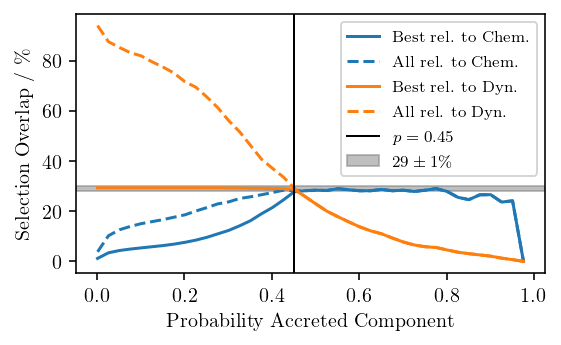

In [7]:
def plot_overlap_versus_probability(
    component = 0,
    dynamical_selection = gse_f21
    ):
    
    f, ax = plt.subplots(figsize=(4,2.5))

    ax.set_xlabel('Probability Accreted Component')
    ax.set_ylabel('Selection Overlap / \%')
    prediction_all = -1*np.ones(np.shape(xdgmm['selection']))
    prediction_all[xdgmm['selection']] = xdgmm['prediction']

    probability_all = np.zeros(np.shape(xdgmm['selection']))
    probability_all[xdgmm['selection']] = xdgmm['accreted_proba']
    #(probability_all[xdgmm['selection']])[(xdgmm['prediction'] != accreted_component)] = 0.

    probability_array = np.arange(0.001,1.0,0.025)
    overlap_x_in_chem_best = []
    overlap_x_in_chem_all = []

    for probability_threshold in probability_array:

        # accreted both chemically and dynamically
        selection1 = (
            (prediction_all == component) &
            (probability_all >= probability_threshold) &
            gse_f21
        )
        selection1b = (
            (probability_all >= probability_threshold) &
            gse_f21
        )

        selection2 = (
            (probability_all >= probability_threshold)
        )
        
        overlap_x_in_chem_best.append(
            len(data['sobject_id'][selection1])/len(data['sobject_id'][selection2]))
        overlap_x_in_chem_all.append(
            len(data['sobject_id'][selection1b])/len(data['sobject_id'][selection2]))
        
    ax.plot(
        probability_array,
        np.array(overlap_x_in_chem_best)*100,
        label='Best rel. to Chem.',color='C0'
    )
    ax.plot(
        probability_array,
        np.array(overlap_x_in_chem_all)*100,
        label='All rel. to Chem.',ls='dashed',color='C0'
    )

    overlap_x_in_dyn_best = []
    overlap_x_in_dyn_all = []

    for probability_threshold in probability_array:

        # accreted both chemically and dynamically
        selection1 = (
            (prediction_all == component) &
            (probability_all >= probability_threshold) &
            gse_f21 & (data['flag_Mg_fe']==0) & (data['flag_Na_fe']==0) & (data['flag_Mn_fe']==0)
        )
        selection1b = (
            (probability_all >= probability_threshold) &
            gse_f21 & (data['flag_Mg_fe']==0) & (data['flag_Na_fe']==0) & (data['flag_Mn_fe']==0)
        )

        selection2 = (
            gse_f21 & (data['flag_Mg_fe']==0) & (data['flag_Na_fe']==0) & (data['flag_Mn_fe']==0)
        )

        overlap_x_in_dyn_best.append(
            len(data['sobject_id'][selection1])/len(data['sobject_id'][selection2]))
        overlap_x_in_dyn_all.append(
            len(data['sobject_id'][selection1b])/len(data['sobject_id'][selection2]))

    ax.plot(
        probability_array,
        np.array(overlap_x_in_dyn_best)*100,
        label='Best rel. to Dyn.',color='C1'
    )

    ax.plot(
        probability_array,
        np.array(overlap_x_in_dyn_all)*100,
        label='All rel. to Dyn.',c='C1',ls='dashed'
    )

    ax.axvline(0.45,c='k',lw=1,label=r'$p = 0.45$')
    ax.axhspan(28,30,color='grey',label=r'$29 \pm 1\%$',alpha=0.5)
    
    ax.legend(fontsize=8)
    
    overlap_table = Table()
    overlap_table['probability'] = probability_array
    overlap_table['overlap_x_in_chem'] = np.array(overlap_x_in_chem_best)
    overlap_table['overlap_x_in_dyn'] = np.array(overlap_x_in_dyn_best)
    print(overlap_table[10:20])
    plt.tight_layout()
    plt.savefig('quantitative_overlap_chemdyn.png',dpi=200,bbox_inches='tight')
plot_overlap_versus_probability()

In [9]:
def tex_table_overlap():
    
    table = [
        [r'\begin{table}'],
        [r'\centering'],
        [r'\caption{Overview of sources selected as accreted. We list the normalised probability $p$ of sources to be selected chemically via the \textsc{xdgmm} of $\mathrm{[Na/Fe]}$ vs. $\mathrm{[Mg/Mn]}$ as well as those dynamically selected based on the suggestion by \citet{Feuillet2021} in the $L_Z$ vs. $\sqrt{J_R}$ plane. The selection criteria are explained in detail in Secs.~\ref{sec:xdgmm_selection} and \ref{sec:dynamical_selection}, respectively. Chemically selected stars, as selected for the analysis throughout this study with $p > 0.45$ are marked in bold.}'],
        [r'\label{tab:xdgmm_dynamical_selection}'],
        [r'\setlength{\tabcolsep}{0.6em}'],
        [r'\begin{tabular}{ccc}'],
        [r'\hline'],
        [r'GALAH+ DR3 & Chemical selection & Dynamical Selection \\'],
        [r'sobject\_id & $p (\mathrm{[Na/Fe]},\mathrm{[Mg/Mn]})$ & $p (L_Z\text{ vs. }\sqrt{J_R})$ \\'],
        ['\hline']
    ]
    
    probability_all = np.zeros(np.shape(xdgmm['selection']))
    probability_all[xdgmm['selection']] = xdgmm['accreted_proba']
    
    ex4 = (probability_all > 0.0) & (probability_all < 0.45) & (~gse_f21)
    table.append([str(data['sobject_id'][ex4][0])+r' & '+"{:.2f}".format(probability_all[ex4][0])+r' & 0 \\'])
    
    ex3 = (probability_all > 0.0) & (probability_all < 0.45) & gse_f21
    table.append([str(data['sobject_id'][ex3][0])+r' & '+"{:.2f}".format(probability_all[ex3][0])+r' & 1 \\'])

    # in both
    ex1 = (probability_all >= 0.45) & gse_f21
    table.append([str(data['sobject_id'][ex1][0])+r' & \textbf{'+"{:.2f}".format(probability_all[ex1][0])+r'} & 1 \\'])

    ex2 = (probability_all >= 0.45) & (~gse_f21)
    table.append([str(data['sobject_id'][ex2][0])+r' & \textbf{'+"{:.2f}".format(probability_all[ex2][0])+r'} & 0 \\'])

    table.append([r'\dots  & \dots  & \dots  \\'])
    table.append([r'\hline'])
    table.append([r'\end{tabular}'])
    table.append([r'\end{table}'])

    print(np.array(table))
    np.savetxt('../tables/selected_stars.tex',np.array(table),fmt='%s')

tex_table_overlap()

[['\\begin{table}']
 ['\\centering']
 ['\\caption{Overview of sources selected as accreted. We list the probability of sources to be selected chemically via the \\textsc{xdgmm} of $\\mathrm{[Na/Fe]}$ vs. $\\mathrm{[Mg/Mn]}$ as well as those dynamically selected based on the suggestion by \\citet{Feuillet2021} in the $L_Z$ vs. $\\sqrt{J_R}$ plane. The selection criteria are explained in detail in Secs.~\\ref{sec:xdgmm_selection} and \\ref{sec:dynamical_selection}, respectively. Chemically selected stars, as selected for the analysis throughout this study with $p > 0.45$ are marked in bold.}']
 ['\\label{tab:xdgmm_dynamical_selection}']
 ['\\setlength{\\tabcolsep}{0.6em}']
 ['\\begin{tabular}{ccc}']
 ['\\hline']
 ['GALAH+ DR3 & Chemical selection & Dynamical Selection \\\\']
 ['sobject\\_id & $p (\\mathrm{[Na/Fe]}\\text{ vs. }\\mathrm{[Mg/Mn]})$ & $p (L_Z\\text{ vs. }\\sqrt{J_R})$ \\\\']
 ['\\hline']
 ['131116000501004 & 0.12 & 0 \\\\']
 ['131116000501201 & 0.03 & 1 \\\\']
 ['14020900170

In [11]:
def supplementary_table_overlap():
    
    table = Table()
    
    probability_all = np.zeros(np.shape(xdgmm['selection']))
    probability_all[xdgmm['selection']] = xdgmm['accreted_proba']
    
    ex4 = (probability_all > 0.0) & (probability_all < 0.45) & (~gse_f21)
    
    ex3 = (probability_all > 0.0) & (probability_all < 0.45) & gse_f21
    
    # in both
    ex1 = (probability_all >= 0.45) & gse_f21
    
    ex2 = (probability_all >= 0.45) & (~gse_f21)
    
    in_one_of_them = (ex4 | ex3 | ex2 | ex1)
    
    table['sobject_id'] = data['sobject_id'][in_one_of_them]
    table['probability_chemical_selection'] = probability_all[in_one_of_them]
    table['probability_dynamical_selection'] = np.array(gse_f21[in_one_of_them].astype('uint8'))

    table.write('../supplementary_material/table5.fits',overwrite=True)
    
supplementary_table_overlap()

# D) Distributions chemical and dynamical selections

In [8]:
ranges = dict()

ranges['fe_h'] = (-2.5,0.5)
for each in ['Li']:
    ranges[each+'_fe'] = (-0.98,2.98)
    ranges['A_Li'] = (-1,4)
for each in ['C','O']:
    ranges[each+'_fe'] = (-0.48,1.48)
for each in ['alpha','Mg','Si','Ca','Ti']:
    ranges[each+'_fe'] = (-0.28,0.58)
for each in ['Na','Al','K','Cr','Mn','Ni']:
    ranges[each+'_fe'] = (-0.74,0.74)
for each in ['Sc']:
    ranges[each+'_fe'] = (-0.48,0.98)
for each in ['Cu']:
    ranges[each+'_fe'] = (-0.98,0.74)
for each in ['V','Co','Zn']:
    ranges[each+'_fe'] = (-0.98,0.84)
for each in ['Rb','Sr','Y','Zr','Ba','La']:
    ranges[each+'_fe'] = (-0.74,1.48)
for each in ['Ru','Ce','Nd','Eu']:
    ranges[each+'_fe'] = (-0.74,1.24)
ranges['MgMn_fe'] = (-0.4,1.2)

ranges['l'] = (0,360)
ranges['l2'] = (-180,180)
ranges['b'] = (-90,90)

ranges['ecc'] = (0,1)
ranges['L_Z'] = (-1950,3250)
ranges['J_R'] = (0,65**2)
ranges['sqrt_J_R'] = (0,65)
ranges['vR_Rzphi'] = (-500,500)
ranges['vT_Rzphi'] = (-300,400)
ranges['Energy'] = (-2.5*10**5,-1.0*10**5)
ranges['Energy_10_5'] = (-2.5,-1.0)

In [9]:
probability_all = np.zeros(np.shape(xdgmm['selection']))
probability_all[xdgmm['selection']] = xdgmm['accreted_proba']

In [10]:
len(np.where(probability_all > 0.45)[0])

1049

In [11]:
def plot_axis_hist2d_accreted_chemical_dynamical(
    ax,
    x_elem = 'fe_h',
    y_elem = 'Mg_fe',
    xdgmm = xdgmm,
    accreted_component = 0,
    dynamical_accreted = gse_f21,
    probability_threshold = 0.25,
    ranges=ranges
    ):

    elements = []
    if x_elem[-3:] == '_fe':
        elements.append(x_elem[:-3])
    else:
        elements.append('Mg')
    if y_elem[-3:] == '_fe':
        elements.append(y_elem[:-3])
    else:
        elements.append('Mg')

    # background
    background_selection = basic_cuts & np.all([(data['flag_'+element+'_fe'] == 0) for element in elements],axis=0)
    corner.hist2d(
        data[x_elem][background_selection],
        data[y_elem][background_selection],
        ax=ax,
        color='k',
        contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
        bins = (
            np.linspace(ranges[x_elem][0],ranges[x_elem][1],30),
            np.linspace(ranges[y_elem][0],ranges[y_elem][1],30)
        ),
        range=[ranges[x_elem],ranges[y_elem]],
        data_kwargs = dict(alpha=0.01)
    )
    
    # accreted
    above_threshold = (
        (xdgmm['prediction_proba'][:,accreted_component] > probability_threshold) &
        np.all([(data['flag_'+element+'_fe'][xdgmm['selection']] == 0) for element in elements],axis=0)
    )
    ax.scatter(
        data[x_elem][xdgmm['selection']][above_threshold],
        data[y_elem][xdgmm['selection']][above_threshold],
        color = 'orange',
        s=1.5,
        edgecolors=None,
        lw=0,
        alpha=0.9
    )
    corner.hist2d(
        data[x_elem][xdgmm['selection']][above_threshold],
        data[y_elem][xdgmm['selection']][above_threshold],
        ax=ax,
        color='orange',
        contour_kwargs = dict(linewidths=[0.5,1,1.5,2]),
        bins = (
            np.linspace(ranges[x_elem][0],ranges[x_elem][1],30),
            np.linspace(ranges[y_elem][0],ranges[y_elem][1],30)
        ),
        weights = xdgmm['prediction_proba'][:,accreted_component][above_threshold],
        range=[ranges[x_elem],ranges[y_elem]],
        #no_fill_contours=True,
        #plot_datapoints=False,
        #plot_density=False,
    )
    
    # accreted dynamical
    dynamical_selection = dynamical_accreted & np.all([(data['flag_'+element+'_fe'] == 0) for element in elements],axis=0)
    
    corner.hist2d(
        data[x_elem][dynamical_selection],
        data[y_elem][dynamical_selection],
        ax=ax,
        color='r',
        contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
        bins = (
            np.linspace(ranges[x_elem][0],ranges[x_elem][1],30),
            np.linspace(ranges[y_elem][0],ranges[y_elem][1],30)
        ),
        range=[ranges[x_elem],ranges[y_elem]],
        no_fill_contours=True,
        plot_datapoints=False,
        plot_density=False,
    )

In [12]:
def plot_selection_comparison_chemistry():
    
    element_groups = dict()
    element_groups['all'] = ['Li','C','O',
                      'Na','Mg','Al','Si','K',
                      'Ca','Sc','Ti','V' ,'Cr',
                      'Mn','Co','Ni','Cu','Zn',
                      'Rb','Sr','Y' ,'Zr','Ba',
                      'La','Ce','Ru','Nd','Eu']
    cols = 4; rows = 7
    figsize=(8.3,10.7)
    dpi=150

    f, gs = plt.subplots(rows,cols,figsize=figsize,sharex=True)

    for each_id, each in enumerate(element_groups['all']):

        if rows == 1:
            ax = gs[each_id]
        else:
            if each_id < cols:
                ax = gs[0,each_id]
            elif each_id < 2*cols:
                ax = gs[1,each_id-cols]
            elif each_id < 3*cols:
                ax = gs[2,each_id-2*cols]
            elif each_id < 4*cols:
                ax = gs[3,each_id-3*cols]
            elif each_id < 5*cols:
                ax = gs[4,each_id-4*cols]
            elif each_id < 6*cols:
                ax = gs[5,each_id-5*cols]
            elif each_id < 7*cols:
                ax = gs[6,each_id-6*cols]
        if each_id >= (rows-1)*cols:
            ax.set_xlabel('[Fe/H]')

        plot_axis_hist2d_accreted_chemical_dynamical(
            ax=ax,
            x_elem = 'fe_h',
            y_elem = each+'_fe',
            xdgmm = xdgmm,
            )

        if each_id%cols==0:
            ax.set_ylabel('[X/Fe]')

        if each in ['Sc','V','Cr','Mn','Co','Ni','Cu','Zn']:
            ax.set_yticks([-0.5,0,0.5,1.0,1.5])

        if each == 'alpha':
            each = r'$\alpha$'
        ax.text(0.05,0.95,each,transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
        ax.axhline(lw=0.2,ls='dashed',color='k')
        ax.axvline(lw=0.2,ls='dashed',color='k')

    plt.tight_layout(h_pad=0,w_pad=0)

    plt.savefig('selection_comparison_chemistry.png',dpi=dpi,bbox_inches='tight')

#plot_selection_comparison_chemistry()

In [13]:
def plot_background(
    ax,
    x_elem = 'fe_h',
    y_elem = 'Mg_fe',
    use_corner = True,
    no_fill_contours=False,
    plot_datapoints=True,
    plot_density=True,
    data_kwargs = dict(alpha=0.01),
    levels=None,
    bins=30
    ):

    elements = []
    if x_elem[-3:] == '_fe':
        elements.append(x_elem[:-3])
    else:
        elements.append('Mg')
    if y_elem[-3:] == '_fe':
        elements.append(y_elem[:-3])
    else:
        elements.append('Mg')
    if y_elem == 'Li_fe':
        y_elem = 'A_Li'

    # background
    background_selection = basic_cuts & np.all([(data['flag_'+element+'_fe'] == 0) for element in elements],axis=0)

    if use_corner:
        corner.hist2d(
            data[x_elem][background_selection],
            data[y_elem][background_selection],
            ax=ax,
            color='k',
            contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
            levels=levels,
            bins = (
                np.linspace(ranges[x_elem][0],ranges[x_elem][1],bins),
                np.linspace(ranges[y_elem][0],ranges[y_elem][1],bins)
            ),
            range=[ranges[x_elem],ranges[y_elem]],
            data_kwargs = data_kwargs,
            no_fill_contours=no_fill_contours,
            plot_datapoints=plot_datapoints,
            plot_density=plot_density,
        )
    else:
        ax.hist2d(
            data[x_elem][background_selection],
            data[y_elem][background_selection],
            cmap='Greys',
            bins = (
                np.linspace(ranges[x_elem][0],ranges[x_elem][1],30),
                np.linspace(ranges[y_elem][0],ranges[y_elem][1],30)
            ),
            no_fill_contours=no_fill_contours,
            plot_datapoints=plot_datapoints,
            plot_density=plot_density,
            norm=LogNorm()
        )

In [115]:
def plot_chemical(
    ax,
    x_elem = 'fe_h',
    y_elem = 'Mg_fe',
    probability_threshold = 0.45,
    component = 0,
    no_fill_contours=True,
    plot_datapoints=False,
    plot_density=False,
    color='orange'
    ):

    elements = []
    if x_elem[-3:] == '_fe':
        elements.append(x_elem[:-3])
    else:
        elements.append('Mg')
    if y_elem[-3:] == '_fe':
        elements.append(y_elem[:-3])
    else:
        elements.append('Mg')
    if y_elem == 'Li_fe':
        yelem = 'A_Li'

    if component == 0:
        # accreted
        above_threshold = (
            (
                (xdgmm['prediction'] == component) &
                (xdgmm['accreted_proba'] >= probability_threshold)
            ) &
            np.all([(data['flag_'+element+'_fe'][xdgmm['selection']] == 0) for element in elements],axis=0)
        )
        weights = 1./xdgmm['accreted_proba'][above_threshold]
        ckwargs= dict()
    else:
        # accreted
        above_threshold = (
            (
                (xdgmm['prediction_proba'][:,component] >= probability_threshold)
            ) &
            np.all([(data['flag_'+element+'_fe'][xdgmm['selection']] == 0) for element in elements],axis=0)
        )
        weights = (1./xdgmm['prediction_proba'][:,component])[above_threshold]
        ckwargs = dict(linewidths = [0.5,1,2])

    #print(len(data[x_elem][xdgmm['selection']][above_threshold]))
        
    corner.hist2d(
        data[x_elem][xdgmm['selection']][above_threshold],
        data[y_elem][xdgmm['selection']][above_threshold],
        ax=ax,
        color=color,
        contour_kwargs = ckwargs,
        bins = (
            np.linspace(ranges[x_elem][0],ranges[x_elem][1],30),
            np.linspace(ranges[y_elem][0],ranges[y_elem][1],30)
        ),
        weights = weights,
        range=[ranges[x_elem],ranges[y_elem]],
        no_fill_contours=no_fill_contours,
        plot_datapoints=plot_datapoints,
        data_kwargs = dict(alpha=0.75),
        plot_density=plot_density,
    );

In [105]:
def plot_dynamical(
    ax,
    x_elem = 'fe_h',
    y_elem = 'Mg_fe',
    dynamical_selection = gse_f21,
    no_fill_contours=True,
    plot_datapoints=False,
    plot_density=False,
    thin=False
    ):

    elements = []
    if x_elem[-3:] == '_fe':
        elements.append(x_elem[:-3])
    else:
        elements.append('Mg')
    if y_elem[-3:] == '_fe':
        elements.append(y_elem[:-3])
    else:
        elements.append('Mg')
    if y_elem == 'Li_fe':
        y_elem = 'A_Li'

    ckwargs = dict()
    if thin:
        ckwargs = dict(linewidths = [0.5,1,2])
        
    # accreted
    selection = (
        dynamical_selection &
        np.all([(data['flag_'+element+'_fe'] == 0) for element in elements],axis=0)
    )
    corner.hist2d(
        data[x_elem][selection],
        data[y_elem][selection],
        ax=ax,
        color='red',
#         contour_kwargs = dict(linewidths=[0.5,1,1.5,2]),
        bins = (
            np.linspace(ranges[x_elem][0],ranges[x_elem][1],30),
            np.linspace(ranges[y_elem][0],ranges[y_elem][1],30)
        ),
        range=[ranges[x_elem],ranges[y_elem]],
        no_fill_contours=no_fill_contours,
        data_kwargs = dict(alpha=0.75),
        plot_datapoints=plot_datapoints,
        plot_density=plot_density,
        contour_kwargs = ckwargs
    );

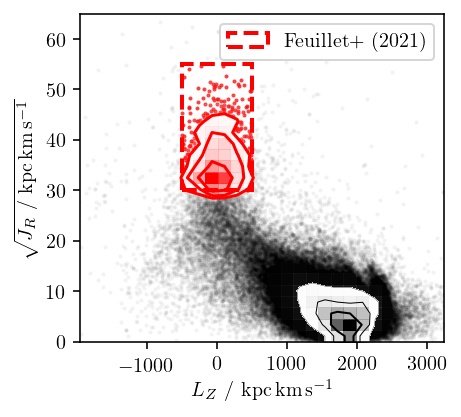

In [106]:
def plot_dynamical_lz_jr(
    probability_threshold = 0.45
    ):
    
    f, ax = plt.subplots(1,1,figsize=(3.3,3),sharex=True,sharey=True)

    x_elem = 'L_Z'
    y_elem = 'sqrt_J_R'
    rect = patches.Rectangle((-500,30),1000,25, linewidth=2, linestyle='dashed', edgecolor='r', facecolor='none',zorder=10,label='Feuillet+ (2021)')
    
    # Individual
    plot_background(ax=ax,x_elem=x_elem,y_elem=y_elem,data_kwargs={'alpha': 0.05})
    plot_dynamical(ax=ax,x_elem=x_elem,y_elem=y_elem,no_fill_contours=False,plot_datapoints=True,plot_density=True)
    ax.add_patch(rect)

    ax.legend()
    ax.set_xlabel(r'$L_Z~/~\mathrm{kpc\,km\,s^{-1}}$')
    ax.set_ylabel(r'$\sqrt{J_R~/~\mathrm{kpc\,km\,s^{-1}}}$')

    plt.tight_layout()
    plt.savefig('Dyn_L_Z_sqrtJ_R.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()

plot_dynamical_lz_jr()

-2.0 -1.875 -1.75
-1.75 -1.625 -1.5
-1.5 -1.375 -1.25
-1.25 -1.125 -1.0
-1.0 -0.875 -0.75
-0.75 -0.625 -0.5


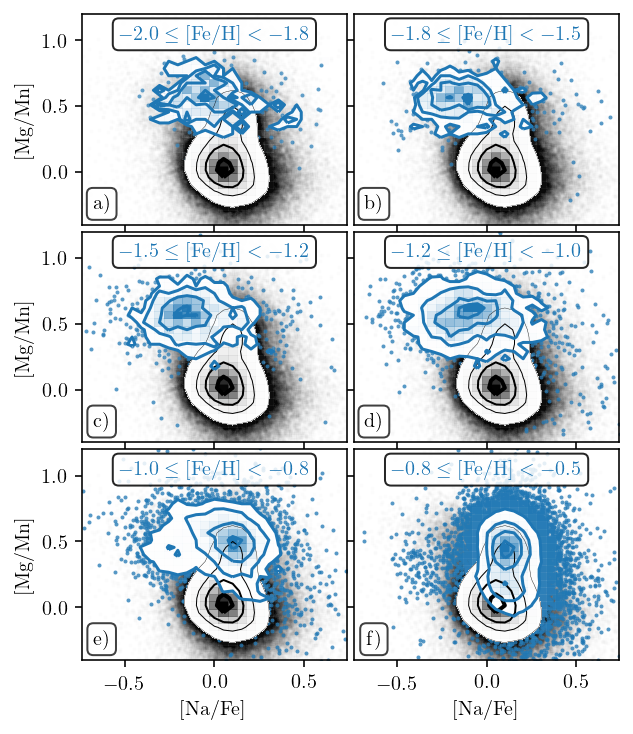

In [107]:
def plot_nafe_mgmn_feh_bins(
    probability_threshold = 0.45,
    fe_h_bins = (-1.875,-0.6),
    fe_h_bin_size = 0.25
    ):
    

    x_elem = 'Na_fe'
    y_elem = 'MgMn_fe'
    
    fe_h_left = np.arange(fe_h_bins[0],fe_h_bins[1]+0.01,fe_h_bin_size)-fe_h_bin_size/2.
    fe_h_right = np.arange(fe_h_bins[0],fe_h_bins[1]+0.01,fe_h_bin_size)+fe_h_bin_size/2.
    
    f, gs = plt.subplots(3,2,figsize=(4.5,5.2),sharex=True,sharey=True)

    for ind, (left, right) in enumerate(zip(fe_h_left,fe_h_right)):
        print(left,left+0.5*fe_h_bin_size,right)
    
        if ind < 2:
            ax=gs[0,ind]
        elif ind < 4:
            ax=gs[1,ind-2]
        else:
            ax=gs[2,ind-4]
            ax.set_xlabel('[Na/Fe]')
        if ind in [0,2,4]:
            ax.set_ylabel('[Mg/Mn]')
        selection = (
            basic_cuts & 
            (data['flag_Na_fe'] == 0) & 
            (data['flag_Mg_fe'] == 0) & 
            (data['flag_Mn_fe'] == 0) &
            (data['fe_h'] >= left) &
            (data['fe_h'] < right)
        )
        
        plot_background(ax=ax,x_elem=x_elem,y_elem=y_elem)

        corner.hist2d(
            data['Na_fe'][selection],
            data['MgMn_fe'][selection],
            color='C0',
            ax=ax,
            bins = (
                np.linspace(ranges[x_elem][0],ranges[x_elem][1],30),
                np.linspace(ranges[y_elem][0],ranges[y_elem][1],30)
            ),
            range=[ranges[x_elem],ranges[y_elem]],
            data_kwargs = dict(alpha=0.75),
        )
        ax.text(0.5,0.88,r'$'+"{:.1f}".format(left)+' \leq \mathrm{[Fe/H]} < '+"{:.1f}".format(right)+'$',transform=ax.transAxes,ha='center',color='C0',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
        ax.text(0.075,0.075,panels[ind],transform=ax.transAxes,ha='center',color='k',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

    plt.tight_layout(h_pad=0,w_pad=0)
    plt.savefig('NaFe_MgMn_FeH_bins.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()

plot_nafe_mgmn_feh_bins()

In [114]:
probability_threshold = 0.45
elements = ['Mg','Na','Mn']

component = 0
# accreted
above_threshold = (
    (
        (xdgmm['accreted_proba'] >= probability_threshold)
    ) &
    np.all([(data['flag_'+element+'_fe'][xdgmm['selection']] == 0) for element in elements],axis=0)
)
print('Orange component')
print(len(data['sobject_id'][xdgmm['selection']][above_threshold]))

component = 3

above_threshold = (
    (
        (xdgmm['prediction_proba'][:,component] >= probability_threshold)
    ) &
    np.all([(data['flag_'+element+'_fe'][xdgmm['selection']] == 0) for element in elements],axis=0)
)
print('Blue component')
print(len(data['sobject_id'][xdgmm['selection']][above_threshold]))

print('ratio')

Orange component
1049
Blue component
2817


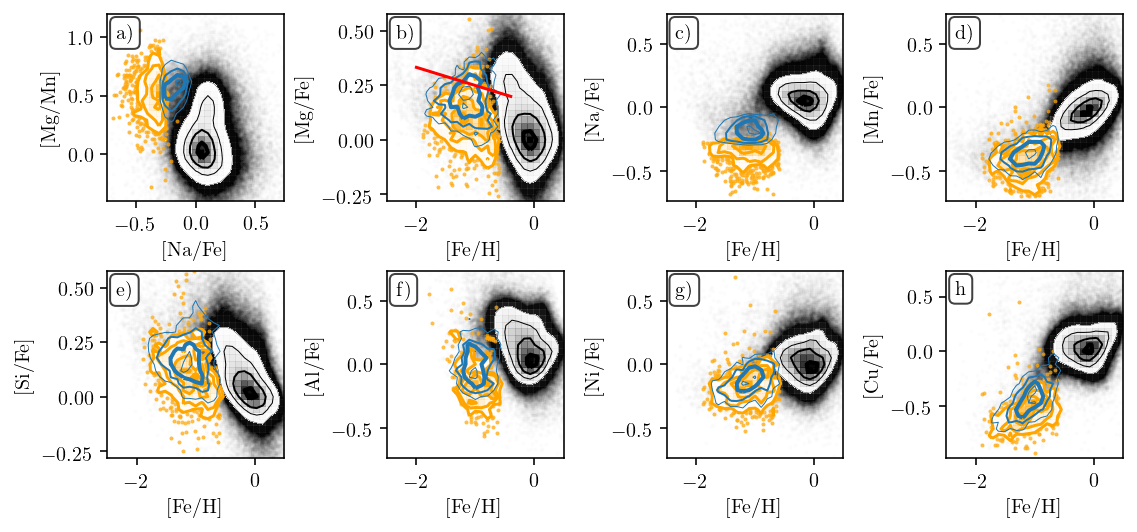

In [123]:
def plot_chemical_accreted_vs_insitu(
    probability_threshold = 0.45
    ):
    
    f, gs = plt.subplots(2,4,figsize=(8,3.8))

    ax = gs[0,0]
    ax.text(0.05,0.95,'a)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    x_elem = 'Na_fe'
    y_elem = 'MgMn_fe'
    plot_background(ax=ax,x_elem=x_elem,y_elem=y_elem)
    plot_chemical(ax=ax,x_elem=x_elem,y_elem=y_elem,no_fill_contours=False,plot_datapoints=True,plot_density=True)
    plot_chemical(ax=ax,x_elem=x_elem,y_elem=y_elem,no_fill_contours=True,plot_datapoints=False,plot_density=False,component=3,color='C0')
    ax.set_xlabel('[Na/Fe]')
    ax.set_ylabel('[Mg/Mn]')
    
    ax = gs[0,1]
    ax.text(0.05,0.95,'b)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    x_elem = 'fe_h'
    y_elem = 'Mg_fe'
    plot_background(ax=ax,x_elem=x_elem,y_elem=y_elem)
    plot_chemical(ax=ax,x_elem=x_elem,y_elem=y_elem,no_fill_contours=False,plot_datapoints=True,plot_density=True)
    plot_chemical(ax=ax,x_elem=x_elem,y_elem=y_elem,no_fill_contours=True,plot_datapoints=False,plot_density=False,component=3,color='C0')
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[Mg/Fe]')
    ax.plot(
        np.linspace(-2,-0.4,10),
        nissen_slope_mg_fe(np.linspace(-2,-0.4,10)),
        color='r'
    )

    ax = gs[0,2]
    ax.text(0.05,0.95,'c)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    x_elem = 'fe_h'
    y_elem = 'Na_fe'
    plot_background(ax=ax,x_elem=x_elem,y_elem=y_elem)
    plot_chemical(ax=ax,x_elem=x_elem,y_elem=y_elem,no_fill_contours=False,plot_datapoints=True,plot_density=True)
    plot_chemical(ax=ax,x_elem=x_elem,y_elem=y_elem,no_fill_contours=True,plot_datapoints=False,plot_density=False,component=3,color='C0')
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[Na/Fe]')

    ax = gs[0,3]
    ax.text(0.05,0.95,'d)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    x_elem = 'fe_h'
    y_elem = 'Mn_fe'
    plot_background(ax=ax,x_elem=x_elem,y_elem=y_elem)
    plot_chemical(ax=ax,x_elem=x_elem,y_elem=y_elem,no_fill_contours=False,plot_datapoints=True,plot_density=True)
    plot_chemical(ax=ax,x_elem=x_elem,y_elem=y_elem,no_fill_contours=True,plot_datapoints=False,plot_density=False,component=3,color='C0')
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[Mn/Fe]')

    ax = gs[1,0]
    ax.text(0.05,0.95,'e)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    x_elem = 'fe_h'
    y_elem = 'Si_fe'
    plot_background(ax=ax,x_elem=x_elem,y_elem=y_elem)
    plot_chemical(ax=ax,x_elem=x_elem,y_elem=y_elem,no_fill_contours=False,plot_datapoints=True,plot_density=True)
    plot_chemical(ax=ax,x_elem=x_elem,y_elem=y_elem,no_fill_contours=True,plot_datapoints=False,plot_density=False,component=3,color='C0')
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[Si/Fe]')

    ax = gs[1,1]
    ax.text(0.05,0.95,'f)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    x_elem = 'fe_h'
    y_elem = 'Al_fe'
    plot_background(ax=ax,x_elem=x_elem,y_elem=y_elem)
    plot_chemical(ax=ax,x_elem=x_elem,y_elem=y_elem,no_fill_contours=False,plot_datapoints=True,plot_density=True)
    plot_chemical(ax=ax,x_elem=x_elem,y_elem=y_elem,no_fill_contours=True,plot_datapoints=False,plot_density=False,component=3,color='C0')
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[Al/Fe]')

    ax = gs[1,2]
    ax.text(0.05,0.95,'g)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    x_elem = 'fe_h'
    y_elem = 'Ni_fe'
    plot_background(ax=ax,x_elem=x_elem,y_elem=y_elem)
    plot_chemical(ax=ax,x_elem=x_elem,y_elem=y_elem,no_fill_contours=False,plot_datapoints=True,plot_density=True)
    plot_chemical(ax=ax,x_elem=x_elem,y_elem=y_elem,no_fill_contours=True,plot_datapoints=False,plot_density=False,component=3,color='C0')
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[Ni/Fe]')

    ax = gs[1,3]
    ax.text(0.05,0.95,'h',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    x_elem = 'fe_h'
    y_elem = 'Cu_fe'
    plot_background(ax=ax,x_elem=x_elem,y_elem=y_elem)
    plot_chemical(ax=ax,x_elem=x_elem,y_elem=y_elem,no_fill_contours=False,plot_datapoints=True,plot_density=True)
    plot_chemical(ax=ax,x_elem=x_elem,y_elem=y_elem,no_fill_contours=True,plot_datapoints=False,plot_density=False,component=3,color='C0')
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[Cu/Fe]')

    plt.tight_layout(h_pad=0.5,w_pad=0.5)
    plt.savefig('nafe_mgmn_overview.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()

plot_chemical_accreted_vs_insitu()

In [24]:
def plot_chemical_dynamical(
    ax,
    x_elem = 'fe_h',
    y_elem = 'Mg_fe',
    probability_threshold = 0.45,
    accreted_component = 0,
    dynamical_selection = gse_f21
    ):

    elements = []
    if x_elem[-3:] == '_fe':
        elements.append(x_elem[:-3])
    else:
        elements.append('Mg')
    if y_elem[-3:] == '_fe':
        elements.append(y_elem[:-3])
    else:
        elements.append('Mg')

    probability_all = np.zeros(np.shape(xdgmm['selection']))
    probability_all[xdgmm['selection']] = xdgmm['accreted_proba']
    #(probability_all[xdgmm['selection']])[(xdgmm['prediction'] != accreted_component)] = 0.
    
    # accreted both chemically and dynamically
    selection = (
        (probability_all >= probability_threshold) &
        dynamical_selection &
        np.all([(data['flag_'+element+'_fe'] == 0) for element in elements],axis=0)
    )
    corner.hist2d(
        data[x_elem][selection],
        data[y_elem][selection],
        ax=ax,
        color='purple',
#         contour_kwargs = dict(linewidths=[0.5,1,1.5,2]),
        bins = (
            np.linspace(ranges[x_elem][0],ranges[x_elem][1],30),
            np.linspace(ranges[y_elem][0],ranges[y_elem][1],30)
        ),
        range=[ranges[x_elem],ranges[y_elem]],
        data_kwargs = dict(alpha=0.75),
        #no_fill_contours=True,
        #plot_datapoints=False,
        #plot_density=False,
    )

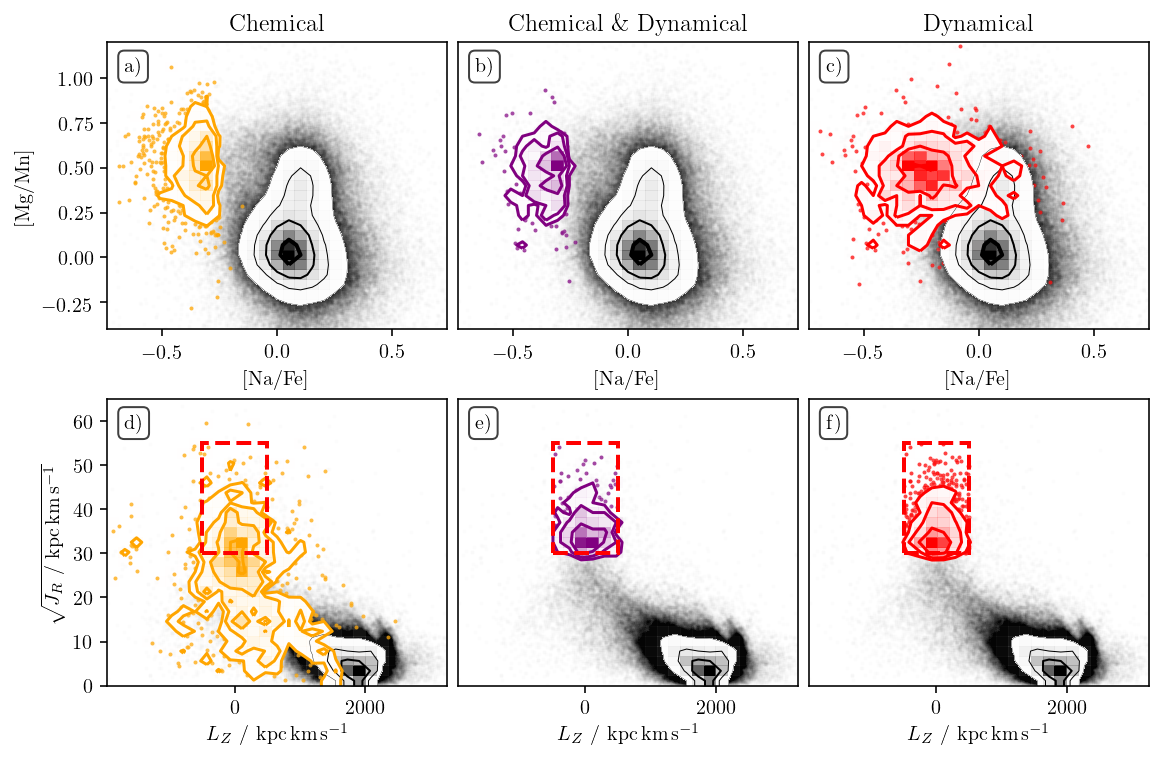

In [30]:
def plot_chemdyn_selection_planes(
    probability_threshold = 0.45
    ):
    f, gs = plt.subplots(2,3,figsize=(8,5.39))

    for i in range(3):
        x_elem = 'Na_fe'
        y_elem = 'MgMn_fe'
    
        if i==0:
            ax=gs[0,0]
            # Individual
            ax.set_title('Chemical')
            ax.text(0.05,0.95,'a)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
            plot_background(ax=ax,x_elem=x_elem,y_elem=y_elem)
            plot_chemical(ax=ax,x_elem=x_elem,y_elem=y_elem,probability_threshold=probability_threshold,no_fill_contours=False,plot_datapoints=True,plot_density=True)
            ax.set_ylabel('[Mg/Mn]')
            
        if i==1:
            ax=gs[0,1]
            # Overlap
            ax.set_title(r'Chemical \& Dynamical')
            ax.text(0.05,0.95,'b)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
            plot_background(ax=ax,x_elem=x_elem,y_elem=y_elem)
            plot_chemical_dynamical(ax=ax,x_elem=x_elem,y_elem=y_elem,probability_threshold=probability_threshold)
            ax.set_yticks([])

        if i==2:
            ax=gs[0,2]
            # Individual
            ax.set_title('Dynamical')
            ax.text(0.05,0.95,'c)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
            plot_background(ax=ax,x_elem=x_elem,y_elem=y_elem)
            plot_dynamical(ax=ax,x_elem=x_elem,y_elem=y_elem,no_fill_contours=False,plot_datapoints=True,plot_density=True)
            ax.set_yticks([])
            
        ax.set_xlabel('[Na/Fe]')

    for i in range(3):
        x_elem = 'L_Z'
        y_elem = 'sqrt_J_R'
    
        rect = patches.Rectangle((-500,30),1000,25, linewidth=2, linestyle='dashed', edgecolor='r', facecolor='none',zorder=10)
        if i==0:
            ax=gs[1,0]
            # Individual
            ax.text(0.05,0.95,'d)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
            plot_background(ax=ax,x_elem=x_elem,y_elem=y_elem)
            plot_chemical(ax=ax,x_elem=x_elem,y_elem=y_elem,probability_threshold=probability_threshold,no_fill_contours=False,plot_datapoints=True,plot_density=True)
            ax.set_ylabel(r'$\sqrt{J_R~/~\mathrm{kpc\,km\,s^{-1}}}$')
            ax.add_patch(rect)

        if i==1:
            ax=gs[1,1]
            # Overlap
            ax.text(0.05,0.95,'e)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
            plot_background(ax=ax,x_elem=x_elem,y_elem=y_elem)
            plot_chemical_dynamical(ax=ax,x_elem=x_elem,y_elem=y_elem,probability_threshold=probability_threshold)
            ax.set_yticks([])
            ax.add_patch(rect)

        if i==2:
            ax=gs[1,2]
            # Individual
            ax.text(0.05,0.95,'f)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
            plot_background(ax=ax,x_elem=x_elem,y_elem=y_elem)
            plot_dynamical(ax=ax,x_elem=x_elem,y_elem=y_elem,no_fill_contours=False,plot_datapoints=True,plot_density=True)
            ax.set_yticks([])
            ax.add_patch(rect)
                
        ax.set_xlabel(r'$L_Z~/~\mathrm{kpc\,km\,s^{-1}}$')
        
    plt.tight_layout(h_pad=0.5,w_pad=0.2)
    plt.savefig('chemdyn_selection_plane.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()

plot_chemdyn_selection_planes()

In [22]:
def table_chronochemodynamic_properties(
    probability_threshold = 0.45,
    text_output = [
        'chem_fe_h','dyn_fe_h',
        'chem_Na_fe','dyn_Na_fe',
        'chem_Al_fe','dyn_Al_fe',
        'chem_MgMn_fe','dyn_MgMn_fe',
        'chemdyn_O_fe','chemdyn_Na_fe','chemdyn_MgMn_fe','chemdyn_Mn_fe','chemdyn_Cu_fe',
        'chem_L_Z','dyn_L_Z',
        'chem_Energy_10_5',
        'chem_ecc','dyn_ecc',
        'chem_vR_Rzphi','dyn_vR_Rzphi',
        'chem_sqrt_J_R','dyn_sqrt_J_R',
        'chem_R_ap',
        'chem_age_bstep',
        'dyn_age_bstep'
        ]
    ):
    full_table = [
        [r'\begingroup'],
        [r'\renewcommand{\arraystretch}{1.19}'],
        [r'\begin{table}'],
        [r'\centering'],
        [r'\caption{Chronochemodynamic properties (shown as $16^\text{th}$/$50^\text{th}$/$84^\text{th}$ percentiles) of the chemical and dynamical selection of accreted stars. We further list the properties of the stars that overlap between both selections. The selection criteria are explained in detail in Secs.~\ref{sec:xdgmm_selection} and \ref{sec:dynamical_selection}, respectively. Only distributions with more than 100 measurements are shown.}'],
        [r'\label{tab:chronochemodynamic_properties}'],
        [r'\begin{tabular}{cccc}'],
        [r'\hline'],
        [r'Property & Chemical & Chemodynamical & Dynamical \\'],
        [r'& Selection & Selection & Selection \\'],
        [r'\hline \hline']
    ]

    properties = [
        'fe_h',
        r'alpha_fe','Li_fe','C_fe','O_fe',
        'Na_fe',
        'Mg_fe',
        'MgMn_fe',
        'Al_fe','Si_fe','K_fe',
        'Ca_fe','Sc_fe','Ti_fe','V_fe' ,'Cr_fe',
        'Mn_fe','Co_fe','Ni_fe','Cu_fe','Zn_fe',
        'Rb_fe','Sr_fe','Y_fe' ,'Zr_fe','Ba_fe',
        'La_fe','Ce_fe','Ru_fe','Nd_fe','Eu_fe',
        'sqrt_J_R',
        'L_Z',
        'J_Z',
        'vR_Rzphi',
        'vT_Rzphi',
        'ecc',
        'Energy_10_5',
        'R_ap',
        'R_peri',
        'zmax',
        'age_bstep_msto'
    ]
    property_names = [
        r'$\mathrm{[Fe/H]}$',
        r'$\mathrm{[\alpha/Fe]}$',
        '$\mathrm{[Li/Fe]}$',
        '$\mathrm{[C/Fe]}$',
        '$\mathrm{[O/Fe]}$',
        r'$\mathrm{[Na/Fe]}$',
        '$\mathrm{[Mg/Fe]}$',
        r'$\mathrm{[Mg/Mn]}$',
        '$\mathrm{[Al/Fe]}$',
        '$\mathrm{[Si/Fe]}$',
        '$\mathrm{[K/Fe]}$',
        '$\mathrm{[Ca/Fe]}$',
        '$\mathrm{[Sc/Fe]}$',
        '$\mathrm{[Ti/Fe]}$',
        '$\mathrm{[V/Fe]}$',
        '$\mathrm{[Cr/Fe]}$',
        '$\mathrm{[Mn/Fe]}$',
        '$\mathrm{[Co/Fe]}$',
        '$\mathrm{[Ni/Fe]}$',
        '$\mathrm{[Cu/Fe]}$',
        '$\mathrm{[Zn/Fe]}$',
        '$\mathrm{[Rb/Fe]}$',
        '$\mathrm{[Sr/Fe]}$',
        '$\mathrm{[Y/Fe]}$',
        '$\mathrm{[Zr/Fe]}$',
        '$\mathrm{[Ba/Fe]}$',
        '$\mathrm{[La/Fe]}$',
        '$\mathrm{[Ce/Fe]}$',
        '$\mathrm{[Ru/Fe]}$',
        '$\mathrm{[Nd/Fe]}$',
        '$\mathrm{[Eu/Fe]}$',
        r'$\sqrt{J_R~/~\mathrm{kpc\,km\,s^{-1}}}$',
        r'$L_Z~/~\mathrm{kpc\,km\,s^{-1}}$',
        r'$J_Z~/~\mathrm{kpc\,km\,s^{-1}}$',
        r'$V_R~/~\mathrm{km\,s^{-1}}$',
        r'$V_\phi~/~\mathrm{km\,s^{-1}}$',
        r'$e$',
        r'$E~/~10^5\,\mathrm{km^{2}\,s^{-2}}$',
        r'$R_\text{ap}~/~\mathrm{kpc}$',
        r'$R_\text{peri}~/~\mathrm{kpc}$',
        r'$z_\text{max}~/~\mathrm{kpc}$',
        r'Age$~/~\mathrm{Gyr}$ (MSTO)'
    ]

    hlines = [31]
    
    for each_ind, (each_property, each_property_name) in enumerate(zip(properties,property_names)):

        if each_ind in hlines:
            full_table.append([r'\hline'])
        
        probability_all = np.zeros(np.shape(xdgmm['selection']))
        probability_all[xdgmm['selection']] = xdgmm['accreted_proba']

        chemical_selection = (probability_all >= probability_threshold)
        if each_property[-3:] in ['_fe']:
            chemical_selection = (
                (probability_all >= probability_threshold) &
                (data['flag_'+each_property] == 0)
            )
        if each_property in ['age_bstep_msto','age_bstep_msto']:
            chemical_selection = (probability_all >= probability_threshold) & msto
            each_property = 'age_bstep'
        pc_16,pc_50,pc_84 = np.percentile(data[each_property][chemical_selection],q=[16,50,84])

        dynamical_selection = gse_f21
        if each_property[-3:] in ['_fe']:
            dynamical_selection = (
                gse_f21 &
                (data['flag_'+each_property] == 0)
            )
        if each_property in ['age_bstep_msto','age_bstep_msto']:
            dynamical_selection = (probability_all >= probability_threshold) & msto
            each_property = 'age_bstep'
        pd_16,pd_50,pd_84 = np.percentile(data[each_property][dynamical_selection],q=[16,50,84])

        chemodynamical_selection = chemical_selection & dynamical_selection
        pcd_16,pcd_50,pcd_84 = np.percentile(data[each_property][chemodynamical_selection],q=[16,50,84])

        if (pc_50-pc_16 > 100) | (pc_84-pc_50 > 100):
            pc_16 = np.round(pc_16,-1)
            pc_50 = np.round(pc_50,-1)
            pc_84 = np.round(pc_84,-1)
        if (pd_50-pd_16 > 100) | (pd_84-pd_50 > 100):
            pd_16 = np.round(pd_16,-1)
            pd_50 = np.round(pd_50,-1)
            pd_84 = np.round(pd_84,-1)
        if (pcd_50-pcd_16 > 100) | (pcd_84-pcd_50 > 100):
            pcd_16 = np.round(pcd_16,-1)
            pcd_50 = np.round(pcd_50,-1)
            pcd_84 = np.round(pcd_84,-1)

        s = ":.2f"
        if (pc_50-pc_16 > 0.01):
            s = "{:.2f}"
            if (pc_50-pc_16 > 0.1):
                s = "{:.2f}"
                if (pc_50-pc_16 > 1):
                    s = "{:.1f}"
                    if (pc_50-pc_16 > 10):
                        s = "{:.0f}"
                        if (pc_50-pc_16 > 100):
                            s = "{:.0f}"

        chem_percentiles = r'$'+s.format(pc_50)+r'_{-'+s.format(pc_50-pc_16)+'}^{+'+s.format(pc_84-pc_50)+'}$'
        chemdyn_percentiles = r'$'+s.format(pcd_50)+r'_{-'+s.format(pcd_50-pcd_16)+'}^{+'+s.format(pcd_84-pcd_50)+'}$'
        dyn_percentiles = r'$'+s.format(pd_50)+r'_{-'+s.format(pd_50-pd_16)+'}^{+'+s.format(pd_84-pd_50)+'}$'
        
        if len(data[each_property][chemical_selection]) < 100:
            chem_percentiles = '-'
        if len(data[each_property][chemodynamical_selection]) < 100:
            chemdyn_percentiles = '-'
        if len(data[each_property][dynamical_selection]) < 100:
            dyn_percentiles = '-'
            
        if each_property == 'fe_h':
            np.savetxt('../depending_text/diff_chemdyn_'+each_property+'.tex',[s.format(pd_50-pc_50)+'%'],fmt='%s')
            np.savetxt('../depending_text/diff_chem_chemdyn_'+each_property+'.tex',[s.format(pcd_50-pc_50)+'%'],fmt='%s')
            np.savetxt('../depending_text/diff_dyn_chemdyn_'+each_property+'.tex',[s.format(pcd_50-pd_50)+'%'],fmt='%s')
            
        # print difference between [X/Fe] for alpha-process elements between chemical and dynamial selections
        if each_property in ['alpha_fe','Mg_fe','Si_fe','Ca_fe','Ti_fe','Cr_fe']:
            np.savetxt('../depending_text/diff_chemdyn_'+each_property+'.tex',[s.format(pd_50-pc_50)+'%'],fmt='%s')
        
        # print how many stars of the dynamical selection have [X/Fe] above the 84th percentile of the chemical one
        if each_property in ['alpha_fe','Mg_fe','Si_fe','Ca_fe','Ti_fe','Na_fe']:
            above_84thchem = dynamical_selection & (data[each_property] > pc_84)
            above_84thchem = "{:.0f}".format(100*len(data[each_property][above_84thchem])/len(data[each_property][dynamical_selection]))
            np.savetxt('../depending_text/above_84thchem_'+each_property+'.tex',[above_84thchem+r'\%'+'%'],fmt='%s')
        
        # how many chemically selected stars have V_\phi > 100 km/s and what are their sqrt(J_R) values?
        if each_property == 'vT_Rzphi':
            above_vphi_100kms = chemical_selection & (data[each_property] > 100) # km/s
            pc_16,pc_50,pc_84 = np.percentile(data['sqrt_J_R'][above_vphi_100kms],q=[16,50,84])
            above_vphi_100kms = "{:.0f}".format(100*len(data[each_property][above_vphi_100kms])/len(data[each_property][chemical_selection]))
            np.savetxt('../depending_text/chem_above_vphi_100kms.tex',[above_vphi_100kms+r'\%'+'%'],fmt='%s')
            np.savetxt('../depending_text/chem_above_vphi_100kms_sqrt_J_R.tex',[r'$'+"{:.1f}".format(pc_50)+r'_{-'+"{:.1f}".format(pc_50-pc_16)+'}^{+'+"{:.1f}".format(pc_84-pc_50)+'}$%'],fmt='%s')
        
        # How many chemically selected stars have J_R < 20**2 / 15**2 / 10**2 kpc kms?
        if each_property == 'sqrt_J_R':
            below_20_20 = chemical_selection & (data[each_property] < 20) # 
            below_20_20 = "{:.0f}".format(100*len(data[each_property][below_20_20])/len(data[each_property][chemical_selection]))
            below_15_15 = chemical_selection & (data[each_property] < 15) # 
            below_15_15 = "{:.0f}".format(100*len(data[each_property][below_15_15])/len(data[each_property][chemical_selection]))
            below_10_10 = chemical_selection & (data[each_property] < 10) # 
            below_10_10 = "{:.0f}".format(100*len(data[each_property][below_10_10])/len(data[each_property][chemical_selection]))
            np.savetxt('../depending_text/chem_below_20_20.tex',[below_20_20+r'\%'+'%'],fmt='%s')
            np.savetxt('../depending_text/chem_below_15_15.tex',[below_15_15+r'\%'+'%'],fmt='%s')
            np.savetxt('../depending_text/chem_below_10_10.tex',[below_10_10+r'\%'+'%'],fmt='%s')

        if each_property == 'age_bstep':
            age_chem = chemical_selection & (msto)
            pc_16,pc_50,pc_84 = np.percentile(data['age_bstep'][age_chem],q=[16,50,84])
            np.savetxt('../depending_text/chem_age_msto.tex',[r'$'+"{:.1f}".format(pc_50)+r'_{-'+"{:.1f}".format(pc_50-pc_16)+'}^{+'+"{:.1f}".format(pc_84-pc_50)+'}$%'],fmt='%s')
            age_dyn = dynamical_selection & (msto)
            pc_16,pc_50,pc_84 = np.percentile(data['age_bstep'][age_dyn],q=[16,50,84])
            np.savetxt('../depending_text/dyn_age_msto.tex',[r'$'+"{:.1f}".format(pc_50)+r'_{-'+"{:.1f}".format(pc_50-pc_16)+'}^{+'+"{:.1f}".format(pc_84-pc_50)+'}$%'],fmt='%s')
           
        
        # How many chemically selected stars have L_Z > 500 and 1000 kpc km/s?
        if each_property == 'L_Z':
            above_500 = chemical_selection & (data[each_property] > 500) # 
            above_500 = "{:.0f}".format(100*len(data[each_property][above_500])/len(data[each_property][chemical_selection]))
            np.savetxt('../depending_text/chem_above_500.tex',[above_500+r'\%'+'%'],fmt='%s')

            above_1000 = chemical_selection & (data[each_property] > 1000) # 
            above_1000 = "{:.0f}".format(100*len(data[each_property][above_1000])/len(data[each_property][chemical_selection]))
            np.savetxt('../depending_text/chem_above_1000.tex',[above_1000+r'\%'+'%'],fmt='%s')
            
            below_m500 = chemical_selection & (data[each_property] < -500) # 
            below_m700 = chemical_selection & (data[each_property] < -700) #
            
            np.savetxt('../depending_text/chem_L_Z_below_m700_number.tex',[str(len(data['fe_h'][below_m700]))+'%'],fmt='%s')
            np.savetxt('../depending_text/chem_L_Z_below_m700_all.tex',[str(len(data['fe_h'][(basic_cuts & (data['L_Z'] < -700))]))+'%'],fmt='%s')

            below_m500 = "{:.0f}".format(100*len(data[each_property][below_m500])/len(data[each_property][chemical_selection]))
            below_m700 = "{:.0f}".format(100*len(data[each_property][below_m700])/len(data[each_property][chemical_selection]))
            np.savetxt('../depending_text/chem_L_Z_below_m500.tex',[below_m500+r'\%'+'%'],fmt='%s')
            np.savetxt('../depending_text/chem_L_Z_below_m700.tex',[below_m700+r'\%'+'%'],fmt='%s')           
            
            wukong1 = chemical_selection & (data['ecc'] < 0.7) & (data['fe_h'] < -1.45)
            wukong1 = "{:.1f}".format(100*len(data[each_property][wukong1])/len(data[each_property][chemical_selection]))
            wukong2 = chemical_selection & (data['ecc'] < 0.7) & (data['fe_h'] < -1.45) & (data['L_Z'] > 200) & (data['L_Z'] < 1000)
            wukong2 = "{:.1f}".format(100*len(data[each_property][wukong2])/len(data[each_property][chemical_selection]))
            np.savetxt('../depending_text/chem_wukong1.tex',[wukong1+r'\%'+'%'],fmt='%s')
            np.savetxt('../depending_text/chem_wukong2.tex',[wukong2+r'\%'+'%'],fmt='%s')
            
        if each_property == 'Energy_10_5':
            above_m18 = chemical_selection & (data[each_property] > -1.8) # 
            above_m20 = chemical_selection & (data[each_property] < -2.0) # 
            pc_16,pc_50,pc_84 = np.percentile(data['R_Rzphi'][above_m20],q=[16,50,84])
            np.savetxt('../depending_text/chem_energy_above_m20_R.tex',[r'$'+"{:.1f}".format(pc_50)+r'_{-'+"{:.1f}".format(pc_50-pc_16)+'}^{+'+"{:.1f}".format(pc_84-pc_50)+'}$%'],fmt='%s')
            pc_16,pc_50,pc_84 = np.percentile(np.abs(data['z_Rzphi'][above_m20]),q=[16,50,84])
            np.savetxt('../depending_text/chem_energy_above_m20_absZ.tex',[r'$'+"{:.1f}".format(pc_50)+r'_{-'+"{:.1f}".format(pc_50-pc_16)+'}^{+'+"{:.1f}".format(pc_84-pc_50)+'}$%'],fmt='%s')
            above_m18 = "{:.0f}".format(100*len(data[each_property][above_m18])/len(data[each_property][chemical_selection]))
            above_m20 = "{:.0f}".format(100*len(data[each_property][above_m20])/len(data[each_property][chemical_selection]))
            np.savetxt('../depending_text/chem_energy_above_m18.tex',[above_m18+r'\%'+'%'],fmt='%s')
            np.savetxt('../depending_text/chem_energy_above_m20.tex',[above_m20+r'\%'+'%'],fmt='%s')
            
        if 'chem_'+each_property in text_output:
            np.savetxt('../depending_text/chem_percentiles_'+each_property+'.tex',[chem_percentiles+'%'],fmt='%s')
        if 'chemdyn_'+each_property in text_output:
            np.savetxt('../depending_text/chemdyn_percentiles_'+each_property+'.tex',[chemdyn_percentiles+'%'],fmt='%s')
        if 'dyn_'+each_property in text_output:
            np.savetxt('../depending_text/dyn_percentiles_'+each_property+'.tex',[dyn_percentiles+'%'],fmt='%s')

        if each_property == 'Li_fe':
            chem_low_A_Li = chemical_selection & (data['A_Li'] < 1.7)
            pc_16,pc_50,pc_84 = np.percentile(data['A_Li'][chem_low_A_Li],q=[16,50,84])
            np.savetxt('../depending_text/chem_low_A_Li.tex',[r'$'+s.format(pc_50)+r'_{-'+s.format(pc_50-pc_16)+'}^{+'+s.format(pc_84-pc_50)+'}$%'],fmt='%s')

            chem_high_A_Li = chemical_selection & (data['A_Li'] >= 1.7)
            pc_16,pc_50,pc_84 = np.percentile(data['A_Li'][chem_high_A_Li],q=[16,50,84])
            np.savetxt('../depending_text/chem_high_A_Li.tex',[r'$'+s.format(pc_50)+r'_{-'+s.format(pc_50-pc_16)+'}^{+'+s.format(pc_84-pc_50)+'}$%'],fmt='%s')

            dyn_low_A_Li = dynamical_selection & (data['A_Li'] < 1.7)
            pc_16,pc_50,pc_84 = np.percentile(data['A_Li'][dyn_low_A_Li],q=[16,50,84])
            np.savetxt('../depending_text/dyn_low_A_Li.tex',[r'$'+s.format(pc_50)+r'_{-'+s.format(pc_50-pc_16)+'}^{+'+s.format(pc_84-pc_50)+'}$%'],fmt='%s')

            dyn_high_A_Li = dynamical_selection & (data['A_Li'] >= 1.7)
            pc_16,pc_50,pc_84 = np.percentile(data['A_Li'][dyn_high_A_Li],q=[16,50,84])
            np.savetxt('../depending_text/dyn_high_A_Li.tex',[r'$'+s.format(pc_50)+r'_{-'+s.format(pc_50-pc_16)+'}^{+'+s.format(pc_84-pc_50)+'}$%'],fmt='%s')

        if each_property != 'age_bstep':
            full_table.append(
                [
                    each_property_name+r' & '+
                    chem_percentiles+
                    ' & '+
                    chemdyn_percentiles+
                    ' & '+
                    dyn_percentiles+
                    r' \\'
                ]
            )

    full_table.append([r'\hline'])
    full_table.append([r'\end{tabular}'])
    full_table.append([r'\end{table}'])
    full_table.append([r'\endgroup'])

    print(np.array(full_table))

    np.savetxt('../tables/chemodyn_comparison.tex',full_table,fmt='%s')

table_chronochemodynamic_properties()

[['\\begingroup']
 ['\\renewcommand{\\arraystretch}{1.19}']
 ['\\begin{table}']
 ['\\centering']
 ['\\caption{Chronochemodynamic properties (shown as 16th/50th/84th percentiles) of the chemical and dynamical selection of accreted stars. We further list the properties of the stars that overlap between both selections. The selection criteria are explained in detail in Secs.~\\ref{sec:xdgmm_selection} and \\ref{sec:dynamical_selection}, respectively. Only distributions with more than 100 measurements are shown.}']
 ['\\label{tab:chronochemodynamic_properties}']
 ['\\begin{tabular}{cccc}']
 ['\\hline']
 ['Property & Chemical & Chemodynamical & Dynamical \\\\']
 ['& Selection & Selection & Selection \\\\']
 ['\\hline \\hline']
 ['$\\mathrm{[Fe/H]}$ & $-1.11_{-0.30}^{+0.28}$ & $-1.03_{-0.29}^{+0.26}$ & $-1.12_{-0.36}^{+0.30}$ \\\\']
 ['$\\mathrm{[\\alpha/Fe]}$ & $0.11_{-0.08}^{+0.07}$ & $0.10_{-0.06}^{+0.07}$ & $0.16_{-0.08}^{+0.11}$ \\\\']
 ['$\\mathrm{[Li/Fe]}$ & - & - & $1.56_{-0.76}^{+1.

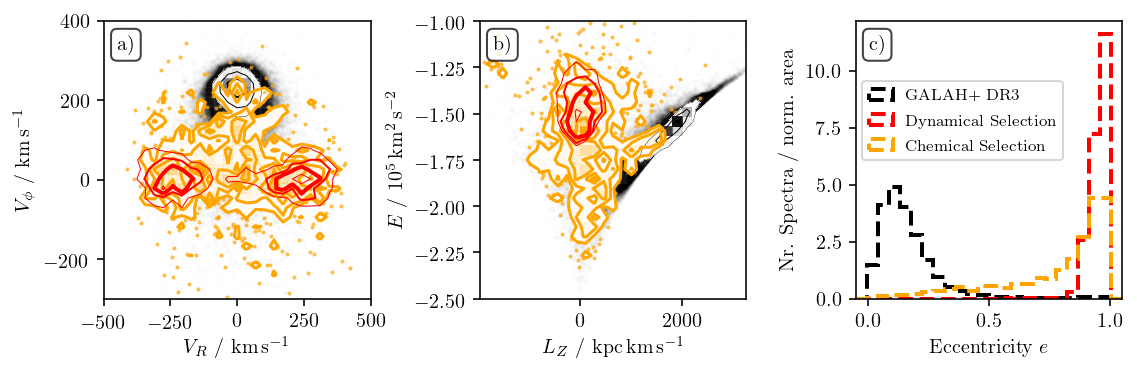

In [20]:
def plot_chemdyn_dynamics(
    probability_threshold = 0.45
    ):
    f, gs = plt.subplots(1,3,figsize=(8,2.7))

    for i in range(3):
    
        if i==0:
            ax=gs[0]
            x_elem = 'vR_Rzphi'
            y_elem = 'vT_Rzphi'
            ax.text(0.05,0.95,'a)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
            plot_background(ax=ax,x_elem=x_elem,y_elem=y_elem)
            plot_chemical(ax=ax,x_elem=x_elem,y_elem=y_elem,no_fill_contours=False,plot_datapoints=True,plot_density=True)
            plot_dynamical(ax=ax,x_elem=x_elem,y_elem=y_elem,no_fill_contours=True,plot_datapoints=False,plot_density=False,thin=True)

            ax.set_xlabel('$V_R~/~\mathrm{km\,s^{-1}}$')
            ax.set_ylabel('$V_\phi~/~\mathrm{km\,s^{-1}}$')
            
        if i==1:
            ax=gs[1]
            x_elem = 'L_Z'
            y_elem = 'Energy_10_5'
            ax.text(0.05,0.95,'b)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
            plot_background(ax=ax,x_elem=x_elem,y_elem=y_elem)
            plot_chemical(ax=ax,x_elem=x_elem,y_elem=y_elem,no_fill_contours=False,plot_datapoints=True,plot_density=True)
            plot_dynamical(ax=ax,x_elem=x_elem,y_elem=y_elem,no_fill_contours=True,plot_datapoints=False,plot_density=False,thin=True)

            ax.set_xlabel('$L_Z~/~\mathrm{kpc\,km\,s^{-1}}$')
            ax.set_ylabel('$E~/~10^5\,\mathrm{km^{2}\\,s^{-2}}$')

        if i==2:
            ax=gs[2]
            ax.text(0.05,0.95,'c)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
            chemical_selection = (probability_all >= probability_threshold)
            dynamical_selection = gse_f21
            chemodynamical_selection = chemical_selection & dynamical_selection

            kwargs = dict(histtype = 'step', linewidth=2,density=True)
            xlim = (-0.05,1.05)
            
            # chemically selected stars
            counts, bins = np.histogram(data['ecc'][basic_cuts], bins=np.linspace(xlim[0],xlim[1],25))
            ax.hist(bins[:-1], bins, weights=counts, color='black', ls='dashed', label='GALAH+ DR3',**kwargs)

            # dynamically selected stars
            counts, bins = np.histogram(data['ecc'][dynamical_selection], bins=np.linspace(xlim[0],xlim[1],25))
            ax.hist(bins[:-1], bins, weights=counts, color='r', ls='dashed', label='Dynamical Selection',**kwargs)

            # chemically selected stars
            counts, bins = np.histogram(data['ecc'][chemical_selection], bins=np.linspace(xlim[0],xlim[1],25))
            ax.hist(bins[:-1], bins, weights=counts, color='orange', ls='dashed', label='Chemical Selection',**kwargs)

            ax.legend(fontsize=8,loc=(0.025,0.5), handlelength=1.5,columnspacing=0.5)
            ax.set_xlim(xlim)
            ax.set_xlabel(r'Eccentricity $e$')
            ax.set_ylabel('Nr. Spectra / norm. area')

    plt.tight_layout(w_pad=0)
    plt.savefig('chemdyn_dynamics.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()

plot_chemdyn_dynamics()

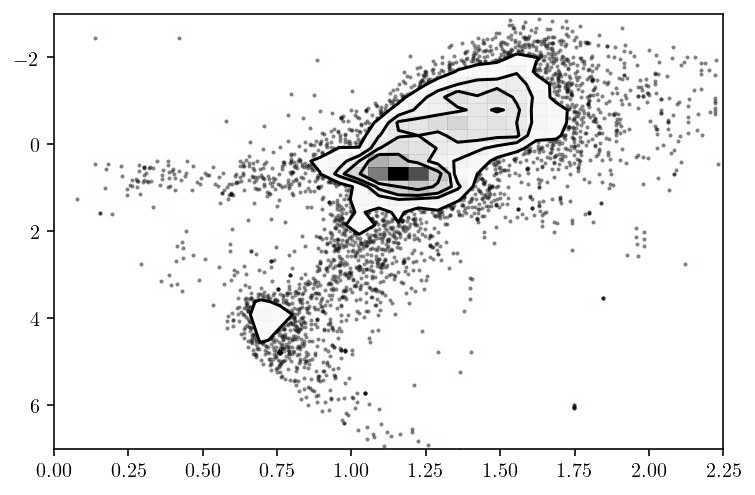

In [24]:
high_v_tan = (
    basic_cuts & 
    (tangential_velocity(data) > 200)
)

nr_bins = 35
ranges['bp_rp'] = (0.,2.25)
ranges['M_G'] = (7,-3)

corner.hist2d(
    data['bp_rp'][high_v_tan],
    data['phot_g_mean_mag'][high_v_tan] - 5*np.log10(data['best_d'][high_v_tan]/10.),
    bins=(np.linspace(ranges['bp_rp'][0],ranges['bp_rp'][1],nr_bins),np.linspace(ranges['M_G'][1],ranges['M_G'][0],nr_bins)),
    range=[ranges['bp_rp'], ranges['M_G']],
    data_kwargs = dict(alpha=0.5),
    levels = (0.15,0.35,0.5,0.7)
)

Median age uncertainty Chem: 53.43643427110013
1049 6.5 2.1 2.1
Median age uncertainty Chem+MSTO: 13.790349913928981
12 11.3 3.1 0.8
Median age uncertainty Dyn: 49.695625015070284
1141 6.9 2.5 2.6
Median age uncertainty Dyn+MSTO: 11.592068094113591
112 11.6 2.4 0.6


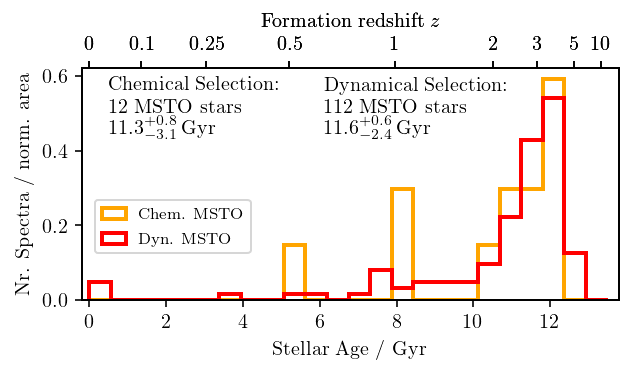

In [21]:
def plot_age_histogram(
    probability_threshold = 0.45
    ):

    cosmo = FlatLambdaCDM(H0=67.4, Om0=0.315)
    redshifts = np.array([0,0.1,0.25,0.5,1,2,3,5,10])
    #redshifts = np.array([0,0.1,0.25,0.5,0.8,1.3,2,3,5,10])
    agevals = np.arange(0, 13.5, 0.1)
    redshiftticks = [cosmo.lookback_time(redshift).to_value() for redshift in redshifts]

    f, gs = plt.subplots(1,1,figsize=(4.5,2.7),sharex=True,sharey=True)

    age_bins = np.linspace(0,13.5,25)

    kwargs = dict(histtype = 'step', linewidth=2,density=True)

    ax=gs
    
    chemical_selection = (probability_all >= probability_threshold)
    dynamical_selection = gse_f21

    # chemically selected stars
    #counts, bins = np.histogram(data['age_bstep'][chemical_selection], bins=age_bins)
    #ax.hist(bins[:-1], bins, weights=counts, color='orange', ls='dashed', label='Chem. All',**kwargs)

    counts, bins = np.histogram(data['age_bstep'][(chemical_selection & msto)], bins=age_bins)
    ax.hist(bins[:-1], bins, weights=counts, color='orange', label='Chem. MSTO',**kwargs)

    ax.set_xlim(-0.2,13.8)
    ax.set_xlabel('Stellar Age / Gyr')
    ax.set_ylabel('Nr. Spectra / norm. area')

    ax1y = ax.twiny()
    ax1y.set_xticks(redshiftticks)
    ax1y.set_xticklabels(['{:g}'.format(redshift) for redshift in redshifts])
    #ax1.set_xlim(-0.2, 13.8)
    ax1y.set_xlim(-0.2, 13.8)
    ax1y.set_xlabel('Formation redshift $z$')
    #ax1.set_xlabel('Stellar Age / Gyr')
    #ax1.minorticks_on()
    
    p = np.percentile(data['age_bstep'][chemical_selection & msto],q=[16,50,84])
    ax.text(0.05,0.9,'Chemical Selection:',transform=ax.transAxes)
    ax.text(0.05,0.8,str(len(data['age_bstep'][chemical_selection & msto]))+r' MSTO stars',transform=ax.transAxes)
    ax.text(0.05,0.7,r'$'+"{:.1f}".format(p[1])+r'_{-'+"{:.1f}".format(p[1]-p[0])+r'}^{+'+"{:.1f}".format(p[2]-p[1])+r'}\,\mathrm{Gyr}$',transform=ax.transAxes)

    ax=gs
    # dynamically selected stars
    #counts, bins = np.histogram(data['age_bstep'][dynamical_selection], bins=age_bins)
    #ax.hist(bins[:-1], bins, weights=counts, color='r', ls='dashed', label='Dyn. All',**kwargs)

    
    counts, bins = np.histogram(data['age_bstep'][(dynamical_selection & msto)], bins=age_bins)
    ax.hist(bins[:-1], bins, weights=counts, color='r', label='Dyn. MSTO',**kwargs)

#    ax.yaxis.set_tick_params(labelright=1,right=1,labelleft=0,left=0)
#    ax.yaxis.set_label_position('right') 
    ax.set_xlim(-0.2,13.8)
    ax.set_xlabel('Stellar Age / Gyr')
    ax.set_ylabel('Nr. Spectra / norm. area')

    ax1y = ax.twiny()
    ax1y.set_xticks(redshiftticks)
    ax1y.set_xticklabels(['{:g}'.format(redshift) for redshift in redshifts])
    #ax1.set_xlim(-0.2, 13.8)
    ax1y.set_xlim(-0.2, 13.8)
    ax1y.set_xlabel('Formation redshift $z$')
    #ax1.set_xlabel('Stellar Age / Gyr')
    #ax1.minorticks_on()

    print('Median age uncertainty Chem:',np.median(100*data['e_age_bstep'][chemical_selection]/data['age_bstep'][chemical_selection]))
    p = np.percentile(data['age_bstep'][chemical_selection],q=[16,50,84])
    print(len(data['age_bstep'][chemical_selection]),"{:.1f}".format(p[1]),"{:.1f}".format(p[1]-p[0]),"{:.1f}".format(p[2]-p[1]))
    print('Median age uncertainty Chem+MSTO:',np.median(100*data['e_age_bstep'][chemical_selection & msto]/data['age_bstep'][chemical_selection & msto]))
    p = np.percentile(data['age_bstep'][chemical_selection & msto],q=[16,50,84])
    print(len(data['age_bstep'][chemical_selection & msto]),"{:.1f}".format(p[1]),"{:.1f}".format(p[1]-p[0]),"{:.1f}".format(p[2]-p[1]))
    print('Median age uncertainty Dyn:',np.median(100*data['e_age_bstep'][dynamical_selection]/data['age_bstep'][dynamical_selection]))
    p = np.percentile(data['age_bstep'][dynamical_selection],q=[16,50,84])
    print(len(data['age_bstep'][dynamical_selection]),"{:.1f}".format(p[1]),"{:.1f}".format(p[1]-p[0]),"{:.1f}".format(p[2]-p[1]))
    print('Median age uncertainty Dyn+MSTO:',np.median(100*data['e_age_bstep'][dynamical_selection & msto]/data['age_bstep'][dynamical_selection & msto]))
    p = np.percentile(data['age_bstep'][dynamical_selection & msto],q=[16,50,84])
    print(len(data['age_bstep'][dynamical_selection & msto]),"{:.1f}".format(p[1]),"{:.1f}".format(p[1]-p[0]),"{:.1f}".format(p[2]-p[1]))
    
    
    p = np.percentile(data['age_bstep'][dynamical_selection & msto],q=[16,50,84])
    ax.text(0.45,0.9,'Dynamical Selection:',transform=ax.transAxes)
    ax.text(0.45,0.8,str(len(data['age_bstep'][dynamical_selection & msto]))+r' MSTO stars',transform=ax.transAxes)
    ax.text(0.45,0.7,r'$'+"{:.1f}".format(p[1])+r'_{-'+"{:.1f}".format(p[1]-p[0])+r'}^{+'+"{:.1f}".format(p[2]-p[1])+r'}\,\mathrm{Gyr}$',transform=ax.transAxes)

    ax.legend(fontsize=8,loc=(0.025,0.2),handlelength=1.5,columnspacing=0.5)

    plt.tight_layout()
    plt.savefig('age_histogram.png',dpi=200,bbox_inches='tight')

plot_age_histogram()

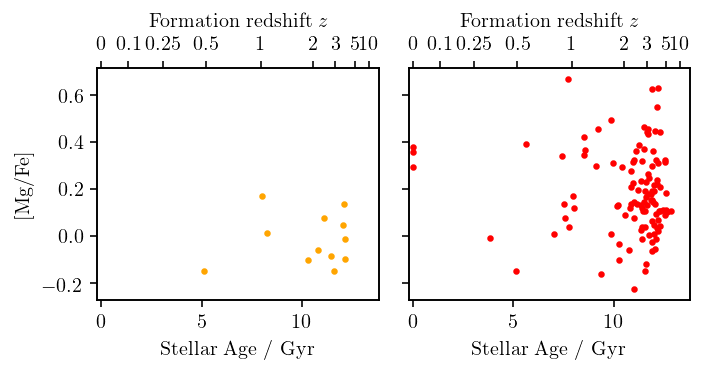

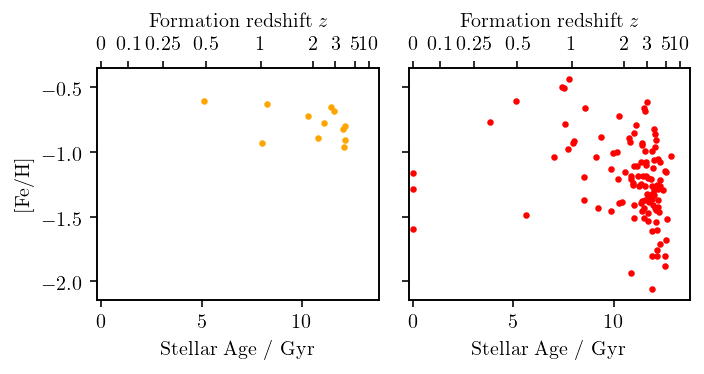

In [37]:
def plot_age_mgfe_trends(
    probability_threshold = 0.45
    ):

    cosmo = FlatLambdaCDM(H0=67.4, Om0=0.315)
    redshifts = np.array([0,0.1,0.25,0.5,1,2,3,5,10])
    #redshifts = np.array([0,0.1,0.25,0.5,0.8,1.3,2,3,5,10])
    agevals = np.arange(0, 13.5, 0.1)
    redshiftticks = [cosmo.lookback_time(redshift).to_value() for redshift in redshifts]

    f, gs = plt.subplots(1,2,figsize=(5,2.7),sharex=True,sharey=True)

    age_bins = np.linspace(0,13.5,25)

    kwargs = dict(histtype = 'step', linewidth=2,density=True)

    ax=gs[0]
    
    chemical_selection = (probability_all >= probability_threshold)
    dynamical_selection = gse_f21

    # chemically selected stars
    #counts, bins = np.histogram(data['age_bstep'][chemical_selection], bins=age_bins)
    #ax.hist(bins[:-1], bins, weights=counts, color='orange', ls='dashed', label='Chem. All',**kwargs)

    counts, bins = np.histogram(data['age_bstep'][(chemical_selection & msto)], bins=age_bins)
    #ax.hist(bins[:-1], bins, weights=counts, color='orange', label='Chem. MSTO',**kwargs)
    ax.scatter(
        data['age_bstep'][(chemical_selection & msto)],
        data['Mg_fe'][(chemical_selection & msto)],
        color='orange', label='Chem. MSTO',s=5
    )
    
    ax.set_xlim(-0.2,13.8)
    ax.set_xlabel('Stellar Age / Gyr')
    ax.set_ylabel('[Mg/Fe]')

    ax1y = ax.twiny()
    ax1y.set_xticks(redshiftticks)
    ax1y.set_xticklabels(['{:g}'.format(redshift) for redshift in redshifts])
    #ax1.set_xlim(-0.2, 13.8)
    ax1y.set_xlim(-0.2, 13.8)
    ax1y.set_xlabel('Formation redshift $z$')
    #ax1.set_xlabel('Stellar Age / Gyr')
    #ax1.minorticks_on()
    
    ax=gs[1]
    # dynamically selected stars
    #counts, bins = np.histogram(data['age_bstep'][dynamical_selection], bins=age_bins)
    #ax.hist(bins[:-1], bins, weights=counts, color='r', ls='dashed', label='Dyn. All',**kwargs)

    ax.scatter(
        data['age_bstep'][(dynamical_selection & msto)],
        data['Mg_fe'][(dynamical_selection & msto)],
        color='r', label='Dyn. MSTO',s=5
    )

#    ax.yaxis.set_tick_params(labelright=1,right=1,labelleft=0,left=0)
#    ax.yaxis.set_label_position('right') 
    ax.set_xlim(-0.2,13.8)
    ax.set_xlabel('Stellar Age / Gyr')
    #ax.set_ylabel('[Mg/Fe]')

    ax1y = ax.twiny()
    ax1y.set_xticks(redshiftticks)
    ax1y.set_xticklabels(['{:g}'.format(redshift) for redshift in redshifts])
    #ax1.set_xlim(-0.2, 13.8)
    ax1y.set_xlim(-0.2, 13.8)
    ax1y.set_xlabel('Formation redshift $z$')
    #ax1.set_xlabel('Stellar Age / Gyr')
    #ax1.minorticks_on()
    
    plt.tight_layout()
    plt.savefig('GSE_age_mgfe.png',dpi=200,bbox_inches='tight')
    
plot_age_mgfe_trends()

def plot_age_feh_trends(
    probability_threshold = 0.45
    ):

    cosmo = FlatLambdaCDM(H0=67.4, Om0=0.315)
    redshifts = np.array([0,0.1,0.25,0.5,1,2,3,5,10])
    #redshifts = np.array([0,0.1,0.25,0.5,0.8,1.3,2,3,5,10])
    agevals = np.arange(0, 13.5, 0.1)
    redshiftticks = [cosmo.lookback_time(redshift).to_value() for redshift in redshifts]

    f, gs = plt.subplots(1,2,figsize=(5,2.7),sharex=True,sharey=True)

    age_bins = np.linspace(0,13.5,25)

    kwargs = dict(histtype = 'step', linewidth=2,density=True)

    ax=gs[0]
    
    chemical_selection = (probability_all >= probability_threshold)
    dynamical_selection = gse_f21

    # chemically selected stars
    #counts, bins = np.histogram(data['age_bstep'][chemical_selection], bins=age_bins)
    #ax.hist(bins[:-1], bins, weights=counts, color='orange', ls='dashed', label='Chem. All',**kwargs)

    counts, bins = np.histogram(data['age_bstep'][(chemical_selection & msto)], bins=age_bins)
    #ax.hist(bins[:-1], bins, weights=counts, color='orange', label='Chem. MSTO',**kwargs)
    ax.scatter(
        data['age_bstep'][(chemical_selection & msto)],
        data['fe_h'][(chemical_selection & msto)],
        color='orange', label='Chem. MSTO',s=5
    )
    
    ax.set_xlim(-0.2,13.8)
    ax.set_xlabel('Stellar Age / Gyr')
    ax.set_ylabel('[Fe/H]')

    ax1y = ax.twiny()
    ax1y.set_xticks(redshiftticks)
    ax1y.set_xticklabels(['{:g}'.format(redshift) for redshift in redshifts])
    #ax1.set_xlim(-0.2, 13.8)
    ax1y.set_xlim(-0.2, 13.8)
    ax1y.set_xlabel('Formation redshift $z$')
    #ax1.set_xlabel('Stellar Age / Gyr')
    #ax1.minorticks_on()
    
    ax=gs[1]
    # dynamically selected stars
    #counts, bins = np.histogram(data['age_bstep'][dynamical_selection], bins=age_bins)
    #ax.hist(bins[:-1], bins, weights=counts, color='r', ls='dashed', label='Dyn. All',**kwargs)

    ax.scatter(
        data['age_bstep'][(dynamical_selection & msto)],
        data['fe_h'][(dynamical_selection & msto)],
        color='r', label='Dyn. MSTO',s=5
    )

#    ax.yaxis.set_tick_params(labelright=1,right=1,labelleft=0,left=0)
#    ax.yaxis.set_label_position('right') 
    ax.set_xlim(-0.2,13.8)
    ax.set_xlabel('Stellar Age / Gyr')
    #ax.set_ylabel('[Fe/H]')

    ax1y = ax.twiny()
    ax1y.set_xticks(redshiftticks)
    ax1y.set_xticklabels(['{:g}'.format(redshift) for redshift in redshifts])
    #ax1.set_xlim(-0.2, 13.8)
    ax1y.set_xlim(-0.2, 13.8)
    ax1y.set_xlabel('Formation redshift $z$')
    #ax1.set_xlabel('Stellar Age / Gyr')
    #ax1.minorticks_on()
    
    plt.tight_layout()
    plt.savefig('GSE_age_feh.png',dpi=200,bbox_inches='tight')
    
plot_age_feh_trends()

In [151]:
print('What is the L_Z of stars with sqrt(J_R) < 20')
chem_and_low_sqrtjr = (probability_all >= 0.45) & (data['sqrt_J_R'] < 20)
p1,p2,p3 = np.percentile(data['L_Z'][chem_and_low_sqrtjr],q=[16,50,84])
np.round(p2),np.round(p2-p1),np.round(p3-p2)

What is the L_Z of stars with sqrt(J_R) < 20


(377.0, 553.0, 709.0)

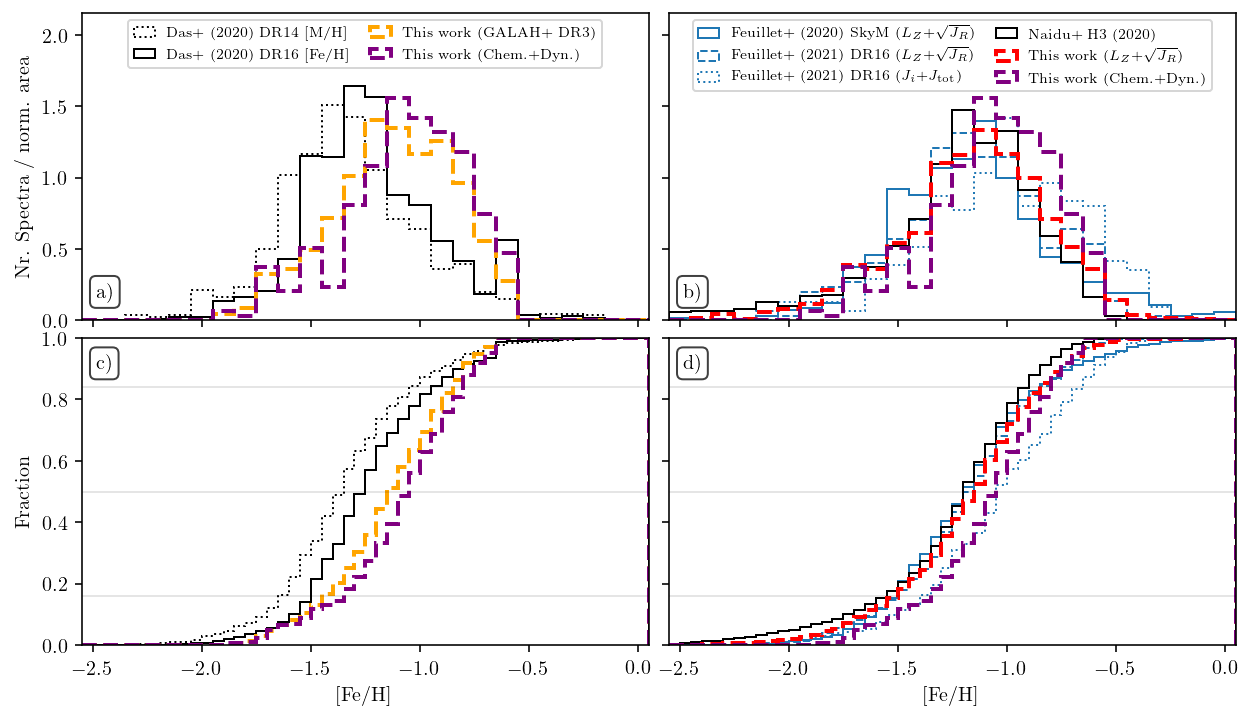

In [78]:
def plot_fe_h_hist_cdf(prop = 'fe_h', prop_name = '[Fe/H]', xlim = (-2.55,0.05),probability_threshold=0.45, nbins1=27, nbins2=53):

    f21_sky = Table.read('../data/Feuillet2021_2105.12141_SkyMapper.fits')
    pc_16,pc_50,pc_84 = np.percentile(f21_sky['fe_h'],q=[16,50,84])
    np.savetxt('../depending_text/feuillet2020_fe_h_skym.tex',[r'$'+"{:.2f}".format(pc_50)+r'_{-'+"{:.2f}".format(pc_50-pc_16)+'}^{+'+"{:.2f}".format(pc_84-pc_50)+'}$ %'],fmt='%s')

    f21_apo = Table.read('../data/Feuillet2021_2105.12141_APOGEE.fits')
    pc_16,pc_50,pc_84 = np.percentile(f21_apo['fe_h'],q=[16,50,84])
    np.savetxt('../depending_text/feuillet2021_fe_h_apo.tex',[r'$'+"{:.2f}".format(pc_50)+r'_{-'+"{:.2f}".format(pc_50-pc_16)+'}^{+'+"{:.2f}".format(pc_84-pc_50)+'}$ %'],fmt='%s')

    f21_m19 = Table.read('../data/Feuillet2021_2105.12141_M19.fits')
    pc_16,pc_50,pc_84 = np.percentile(f21_m19['fe_h'],q=[16,50,84])
    np.savetxt('../depending_text/feuillet2021_fe_h_m19.tex',[r'$'+"{:.2f}".format(pc_50)+r'_{-'+"{:.2f}".format(pc_50-pc_16)+'}^{+'+"{:.2f}".format(pc_84-pc_50)+'}$ %'],fmt='%s')

    n21 = Table.read('../data/Naidu2020_ApJ_901_48.fits')
    n21_gse = n21[(n21['Substructure_ID']=='GSE')]
    pc_16,pc_50,pc_84 = np.percentile(n21_gse['FeH'],q=[16,50,84])
    np.savetxt('../depending_text/naidu2021_fe_h.tex',[r'$'+"{:.2f}".format(pc_50)+r'_{-'+"{:.2f}".format(pc_50-pc_16)+'}^{+'+"{:.2f}".format(pc_84-pc_50)+'}$ %'],fmt='%s')

    das21_1 = Table.read('../data/Das2020_MNRAS_493_5195.fits')
    das21_2 = Table.read('../data/Das2020_MNRAS_493_5195_APOGEE_DR16.fits')
    
    np.percentile(das21_1['apogee_m_h'],q=[16,50,84])
    pc_16,pc_50,pc_84 = np.percentile(das21_1['apogee_m_h'],q=[16,50,84])
    np.savetxt('../depending_text/das2020_m_h_dr14.tex',[r'$'+"{:.2f}".format(pc_50)+r'_{-'+"{:.2f}".format(pc_50-pc_16)+'}^{+'+"{:.2f}".format(pc_84-pc_50)+'}$ %'],fmt='%s')
    pc_16,pc_50,pc_84 = np.percentile(das21_2['FE_H'],q=[16,50,84])
    np.savetxt('../depending_text/das2020_fe_h_dr16.tex',[r'$'+"{:.2f}".format(pc_50)+r'_{-'+"{:.2f}".format(pc_50-pc_16)+'}^{+'+"{:.2f}".format(pc_84-pc_50)+'}$ %'],fmt='%s')

    f, gs = plt.subplots(2,2,figsize=(9,5.1),sharex=True)

    kwargs1 = dict(histtype = 'step', linewidth=1,density=True)
    kwargs2 = dict(histtype = 'step', linewidth=2,density=True)
    
    chemical_selection = (probability_all >= probability_threshold)
    dynamical_selection = gse_f21
    chemodynamical_selection = chemical_selection & dynamical_selection

    # Feuillet et al. 2020 Skymapper
    counts, bins = np.histogram(f21_sky['fe_h'], bins=np.linspace(xlim[0],xlim[1],nbins1))
    gs[0,1].hist(bins[:-1], bins, weights=counts, color = 'C0', label=r'Feuillet+ (2020) SkyM ($L_Z$+$\sqrt{J_R}$)',**kwargs1)

    # Feuillet et al. 2021 APOGEE
    counts, bins = np.histogram(f21_apo['fe_h'], bins=np.linspace(xlim[0],xlim[1],nbins1))
    gs[0,1].hist(bins[:-1], bins, weights=counts, color = 'C0', ls='dashed', label=r'Feuillet+ (2021) DR16 ($L_Z$+$\sqrt{J_R})$',**kwargs1)

    # Feuillet et al. 2021 Myeong
    counts, bins = np.histogram(f21_m19['fe_h'], bins=np.linspace(xlim[0],xlim[1],nbins1))
    gs[0,1].hist(bins[:-1], bins, weights=counts, color = 'C0', ls='dotted', label=r'Feuillet+ (2021) DR16 ($J_i$+$J_\text{tot}$)',**kwargs1)

    # Das et al. 2020
    counts, bins = np.histogram(das21_1['apogee_m_h'], bins=np.linspace(xlim[0],xlim[1],nbins1))
    gs[0,0].hist(bins[:-1], bins, weights=counts, color='k', ls='dotted', label='Das+ (2020) DR14 [M/H]',**kwargs1)
    counts, bins = np.histogram(das21_2['FE_H'], bins=np.linspace(xlim[0],xlim[1],nbins1))
    gs[0,0].hist(bins[:-1], bins, weights=counts, color='k', label='Das+ (2020) DR16 [Fe/H]',**kwargs1)
    
    # Naidu et al. 2020
    counts, bins = np.histogram(n21_gse['FeH'], bins=np.linspace(xlim[0],xlim[1],nbins1))
    gs[0,1].hist(bins[:-1], bins, weights=counts, color='k', label='Naidu+ H3 (2020)',**kwargs1)

    # chemically selected stars
    counts, bins = np.histogram(data[prop][chemical_selection], bins=np.linspace(xlim[0],xlim[1],nbins1))
    gs[0,0].hist(bins[:-1], bins, weights=counts, color='orange', ls='dashed', label=r'This work (GALAH+ DR3)',**kwargs2)

    # dynamically selected stars
    counts, bins = np.histogram(data[prop][dynamical_selection], bins=np.linspace(xlim[0],xlim[1],nbins1))
    gs[0,1].hist(bins[:-1], bins, weights=counts, color='r', ls='dashed', label=r'This work ($L_Z$+$\sqrt{J_R}$)',**kwargs2)

    # chemodynamically selected stars
    counts, bins = np.histogram(data[prop][chemodynamical_selection], bins=np.linspace(xlim[0],xlim[1],nbins1))
    gs[0,0].hist(bins[:-1], bins, weights=counts, color='purple', ls='dashed', label='This work (Chem.+Dyn.)',**kwargs2)
    gs[0,1].hist(bins[:-1], bins, weights=counts, color='purple', ls='dashed', label='This work (Chem.+Dyn.)',**kwargs2)

    gs[0,0].legend(ncol=2,fontsize=7,loc='upper center',handlelength=1.5,columnspacing=1.5)
    gs[0,1].legend(ncol=2,fontsize=7,loc='upper center',handlelength=1.5,columnspacing=1.5)
    gs[0,0].set_xlim(xlim)
    gs[0,1].set_xlim(xlim)
    gs[0,0].set_ylabel('Nr. Spectra / norm. area')
    #gs[0,1].set_ylabel('Nr. Spectra / norm. area')
    
    gs[0,0].text(0.025,0.125,'a)',transform=gs[0,0].transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))        
    gs[0,1].text(0.025,0.125,'b)',transform=gs[0,1].transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    gs[0,1].set_yticks([0,0.5,1.0,1.5,2])

    # Feuillet et al. 2020 Skymapper
    counts, bins = np.histogram(f21_sky['fe_h'], bins=np.linspace(xlim[0],xlim[1],nbins2))
    gs[1,1].hist(bins[:-1], bins, weights=counts, cumulative=True, color = 'C0', label=r'Feuillet+ (2020) SkyM ($L_Z$+$\sqrt{J_R}$)',**kwargs1)

    # Feuillet et al. 2021 APOGEE
    counts, bins = np.histogram(f21_apo['fe_h'], bins=np.linspace(xlim[0],xlim[1],nbins2))
    gs[1,1].hist(bins[:-1], bins, weights=counts, cumulative=True, color = 'C0', ls='dashed', label=r'Feuillet+ (2021) DR16 ($L_Z$+$\sqrt{J_R})$',**kwargs1)

    # Feuillet et al. 2021 Myeong
    counts, bins = np.histogram(f21_m19['fe_h'], bins=np.linspace(xlim[0],xlim[1],nbins2))
    f3 = gs[1,1].hist(bins[:-1], bins, weights=counts, cumulative=True, color = 'C0', ls='dotted', label=r'Feuillet+ (2021) DR16 ($J_i$+$J_\text{tot}$)',**kwargs1)

    # Das et al. 2020
    counts, bins = np.histogram(das21_1['apogee_m_h'], bins=np.linspace(xlim[0],xlim[1],nbins2))
    gs[1,0].hist(bins[:-1], bins, weights=counts, cumulative=True, color='k', ls='dotted', label='Das+ (2020) DR14 [M/H]',**kwargs1)
    counts, bins = np.histogram(das21_2['FE_H'], bins=np.linspace(xlim[0],xlim[1],nbins2))
    gs[1,0].hist(bins[:-1], bins, weights=counts, cumulative=True, color='k', label='Das+ (2020) DR16 [Fe/H]',**kwargs1)
    
    # Naidu et al. 2020
    counts, bins = np.histogram(n21_gse['FeH'], bins=np.linspace(xlim[0],xlim[1],nbins2))
    f4 = gs[1,1].hist(bins[:-1], bins, weights=counts, cumulative=True, color='k', label='Naidu+ H3 (2020)',**kwargs1)

    # chemically selected stars
    counts, bins = np.histogram(data[prop][chemical_selection], bins=np.linspace(xlim[0],xlim[1],nbins2))
    gs[1,0].hist(bins[:-1], bins, weights=counts, cumulative=True, color='orange', ls='dashed', label=r'This work (GALAH+ DR3)',**kwargs2)

    # dynamically selected stars
    counts, bins = np.histogram(data[prop][dynamical_selection], bins=np.linspace(xlim[0],xlim[1],nbins2))
    f5 = gs[1,1].hist(bins[:-1], bins, weights=counts, cumulative=True, color='r', ls='dashed', label=r'This work ($L_Z$+$\sqrt{J_R}$)',**kwargs2)

    # chemodynamically selected stars
    counts, bins = np.histogram(data[prop][chemodynamical_selection], bins=np.linspace(xlim[0],xlim[1],nbins2))
    gs[1,0].hist(bins[:-1], bins, weights=counts, cumulative=True, color='purple', ls='dashed', label='This work (Chem.+Dyn.)',**kwargs2)
    f6 = gs[1,1].hist(bins[:-1], bins, weights=counts, cumulative=True, color='purple', ls='dashed', label='This work (Chem.+Dyn.)',**kwargs2)

    #gs[1,0].legend(fontsize=7,loc='upper left',handlelength=1.5,columnspacing=1.5)
    #gs[1,1].legend(fontsize=7,loc='upper left',handlelength=1.5,columnspacing=1.5)
    gs[1,0].set_xlim(xlim)
    gs[1,1].set_xlim(xlim)
    gs[1,0].set_xlabel(prop_name)
    gs[1,1].set_xlabel(prop_name)
    gs[1,0].set_ylabel('Fraction')
    #gs[1,1].set_ylabel('Nr. Spectra / norm. area')
#    gs[1,0].set_ylim(0,2.25)
    
    gs[1,0].text(0.025,0.95,'c)',transform=gs[1,0].transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))        
    gs[1,1].text(0.025,0.95,'d)',transform=gs[1,1].transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

    gs[0,0].set_ylim(0,2.15)
    gs[0,1].set_ylim(0,2.15)
    gs[1,0].set_ylim(0,1)
    gs[1,1].set_ylim(0,1)

    gs[1,0].axhline(0.16,lw=0.1,c='k')
    gs[1,0].axhline(0.50,lw=0.1,c='k')
    gs[1,0].axhline(0.84,lw=0.1,c='k')
    gs[1,1].axhline(0.16,lw=0.1,c='k')
    gs[1,1].axhline(0.50,lw=0.1,c='k')
    gs[1,1].axhline(0.84,lw=0.1,c='k')
    gs[1,1].set_yticklabels([])
    gs[0,1].set_yticklabels([])

    plt.tight_layout(h_pad=0,w_pad=-1)
    plt.savefig(prop+'_hist_cdf.png',dpi=300,bbox_inches='tight')
plot_fe_h_hist_cdf()

Actions for Das et al. (2020)
$\sqrt{J_R \kpckms} = 30_{-10}^{+11}$
$L_Z = -10_{-590}^{+612} \kpckms$
how many stars show L_Z > 500: 19\%


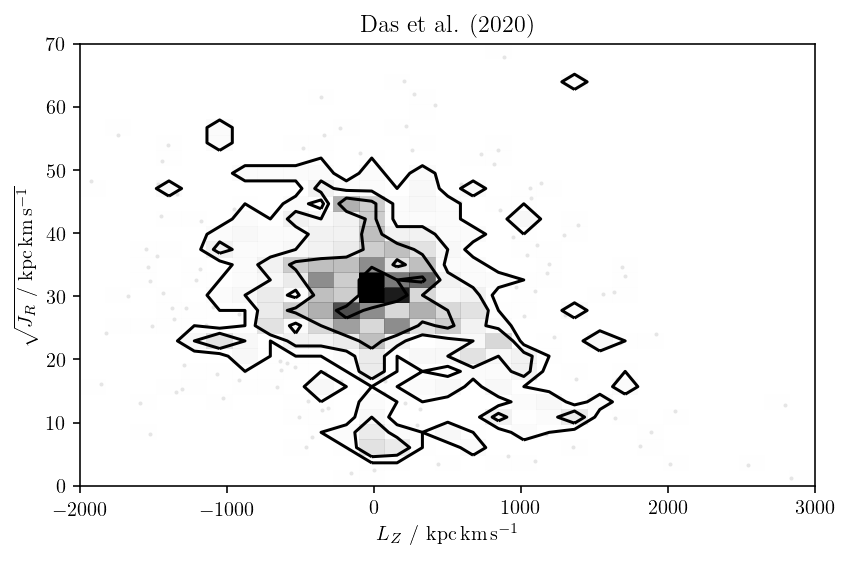

In [72]:
print('Actions for Das et al. (2020)')
das21_1 = Table.read('../data/Das2020_MNRAS_493_5195.fits')
p16,p50,p84 = np.percentile(np.sqrt(das21_1['JR_new']),q=[16,50,84])
print(r'$\sqrt{J_R \kpckms} = '+"{:.0f}".format(p50)+'_{-'+"{:.0f}".format(p50-p16)+'}^{+'+"{:.0f}".format(p84-p50)+'}$')
p16,p50,p84 = np.percentile(das21_1['Lz_new'],q=[16,50,84])
print(r'$L_Z = '+"{:.0f}".format(np.round(p50/10)*10)+'_{-'+"{:.0f}".format(((p50-p16)/10)*10)+'}^{+'+"{:.0f}".format(((p84-p50)/10)*10)+'} \kpckms$')
high_lz = das21_1['Lz_new'] > 500
print('how many stars show L_Z > 500: '+"{:.0f}".format(100*len(das21_1[high_lz])/len(das21_1))+'\%')
f,ax=plt.subplots()
corner.hist2d(
    das21_1['Lz_new'],
    np.sqrt(das21_1['JR_new']),
    bins=(np.linspace(-2000,3000,30),np.linspace(0,70,30)),
    ax=ax
)
ax.set_xlim(-2000,3000)
ax.set_ylim(0,70)
ax.set_title('Das et al. (2020)')
ax.set_xlabel(r'$L_Z~/~\mathrm{kpc\,km\,s^{-1}}$')
ax.set_ylabel(r'$\sqrt{J_R~/~\mathrm{kpc\,km\,s^{-1}}}$')
plt.tight_layout()

In [33]:
def compare_das2020_feh_values():
    probability_all = np.zeros(np.shape(xdgmm['selection']))
    probability_all[xdgmm['selection']] = xdgmm['accreted_proba']

    chemical_selection = (probability_all >= 0.45)
    das21_2 = Table.read('../data/Das2020_MNRAS_493_5195_APOGEE_DR16.fits')
    das21_2['star_id_1'] = das21_2['TMASS_ID']

    das_joined_chem = join(das21_2, data[chemical_selection],keys='star_id_1')
    das_joined_dyn = join(das21_2, data[gse_f21],keys='star_id_1')

    pc_16,pc_50,pc_84 = np.percentile(das_joined_chem['FE_H'],q=[16,50,84])
    np.savetxt('../depending_text/das2020_feh_chem.tex',[r'$'+"{:.2f}".format(pc_50)+r'_{-'+"{:.2f}".format(pc_50-pc_16)+'}^{+'+"{:.2f}".format(pc_84-pc_50)+'}$%'],fmt='%s')
    pc_16,pc_50,pc_84 = np.percentile(das_joined_chem['fe_h']-das_joined_chem['FE_H'],q=[16,50,84])
    np.savetxt('../depending_text/das2020_feh_chem_diff.tex',[r'$'+"{:.2f}".format(pc_50)+r'_{-'+"{:.2f}".format(pc_50-pc_16)+'}^{+'+"{:.2f}".format(pc_84-pc_50)+'}$%'],fmt='%s')
    
    print('Stars in Das2020 overlapping with our dynamcial selection:')
    print(np.array(das_joined_dyn['FE_H']))
    print('Difference between their and our [Fe/H]:')
    print("{:.2f}".format(np.mean(das_joined_dyn['FE_H'] - das_joined_dyn['fe_h'])))
compare_das2020_feh_values()

Stars in Das2020 overlapping with our dynamcial selection:
[-1.5908616 -1.1238616]
Difference between their and our [Fe/H]:
-0.11


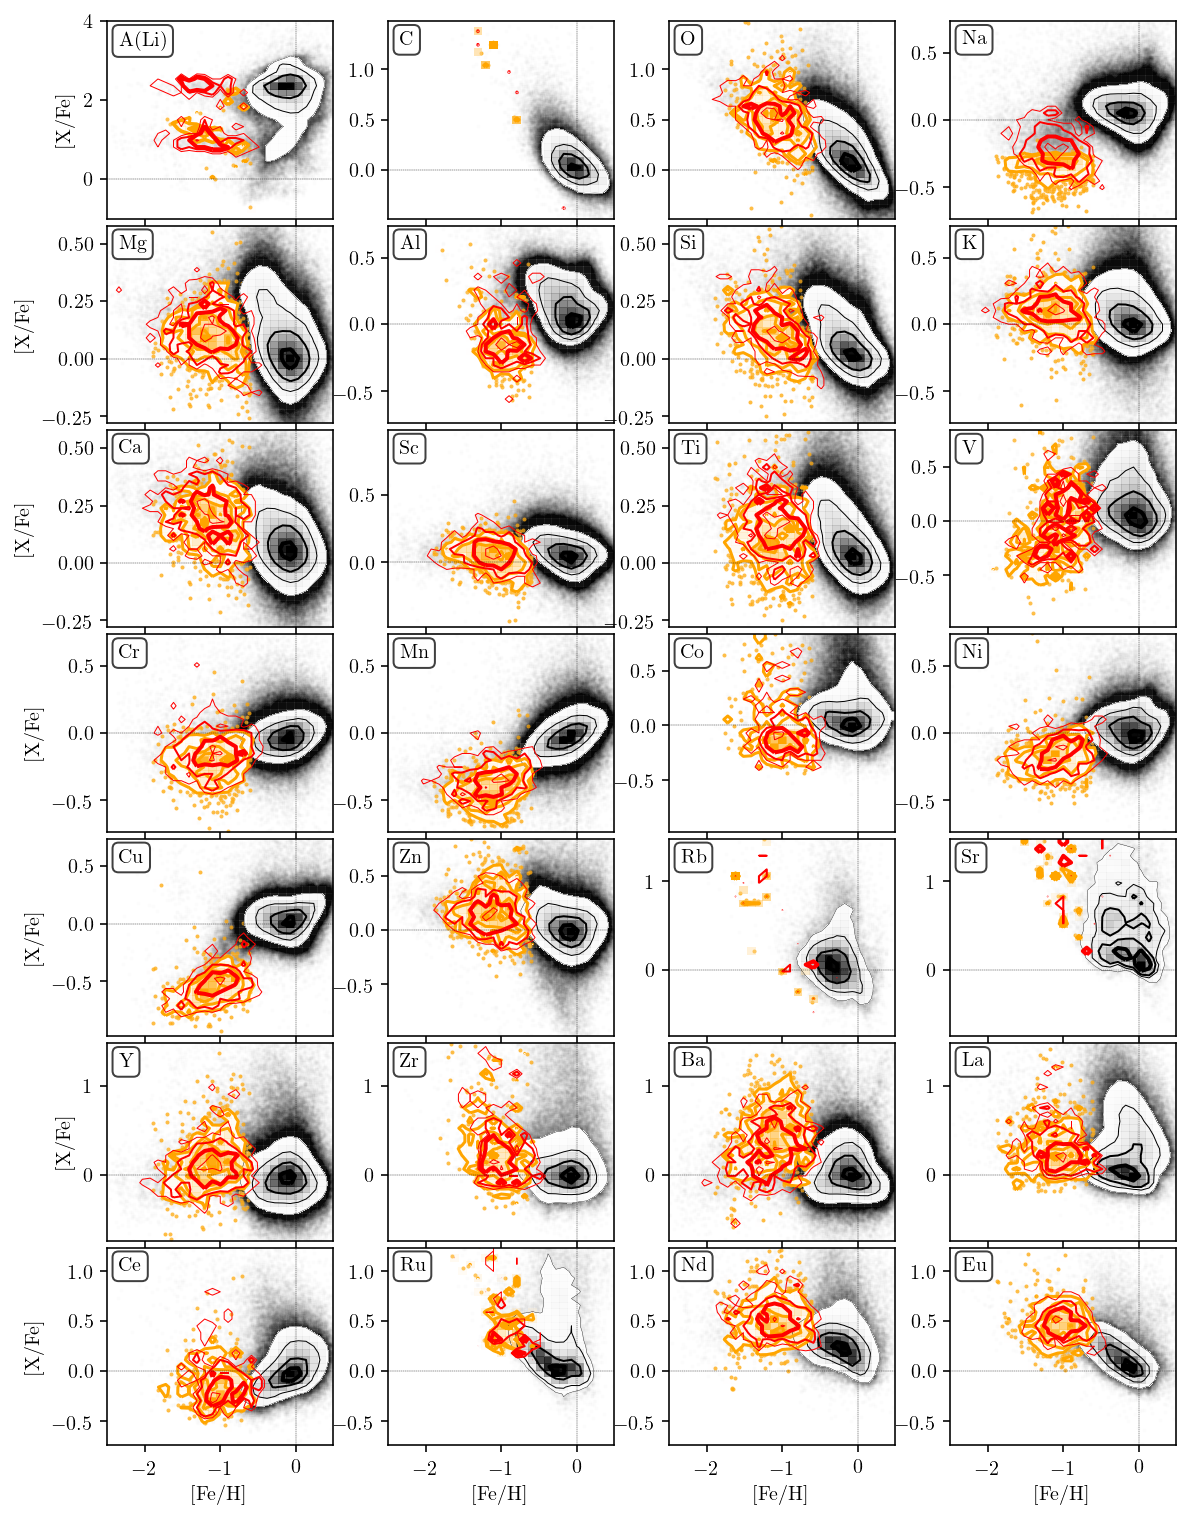

In [32]:
def plot_chemdyn_chemistry():
    
    elements = ['Li','C','O','Na',
                  'Mg','Al','Si','K',
                  'Ca','Sc','Ti','V' ,'Cr',
                  'Mn','Co','Ni','Cu','Zn',
                  'Rb','Sr','Y' ,'Zr','Ba',
                  'La','Ce','Ru','Nd','Eu']
    
    cols = 4; rows = 7
    figsize=(8.3,10.65)
    dpi=150
    
    f, gs = plt.subplots(rows,cols,figsize=figsize,sharex=True)

    for each_id, each in enumerate(elements):

        if rows == 1:
            ax = gs[each_id]
        else:
            if each_id < cols:
                ax = gs[0,each_id]
            elif each_id < 2*cols:
                ax = gs[1,each_id-cols]
            elif each_id < 3*cols:
                ax = gs[2,each_id-2*cols]
            elif each_id < 4*cols:
                ax = gs[3,each_id-3*cols]
            elif each_id < 5*cols:
                ax = gs[4,each_id-4*cols]
            elif each_id < 6*cols:
                ax = gs[5,each_id-5*cols]
            elif each_id < 7*cols:
                ax = gs[6,each_id-6*cols]
        if each_id >= (rows-1)*cols:
            ax.set_xlabel('[Fe/H]')
                
        plot_background(ax=ax,x_elem='fe_h',y_elem=each+'_fe')
        plot_chemical(ax=ax,x_elem='fe_h',y_elem=each+'_fe',no_fill_contours=False,plot_datapoints=True,plot_density=True)
        #plot_chemical(ax=ax,x_elem='fe_h',y_elem=each+'_fe',no_fill_contours=True,plot_datapoints=False,plot_density=False)
        plot_dynamical(ax=ax,x_elem='fe_h',y_elem=each+'_fe',no_fill_contours=True,plot_datapoints=False,plot_density=False,thin=True)

        if each_id%cols==0:
            ax.set_ylabel('[X/Fe]')
            
#         if each in ['Sc','V','Cr','Mn','Co','Ni','Cu','Zn']:
#             ax.set_yticks([-0.5,0,0.5,1.0,1.5])

        if each == 'alpha':
            each = r'$\alpha$'
        if each == 'Li':
            each = 'A(Li)'
        ax.text(0.05,0.95,each,transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
        ax.axhline(lw=0.2,ls='dashed',color='k')
        ax.axvline(lw=0.2,ls='dashed',color='k')

    plt.tight_layout(h_pad=0,w_pad=0)
    plt.savefig('chemdyn_chemistry.png',dpi=dpi,bbox_inches='tight')

plot_chemdyn_chemistry()

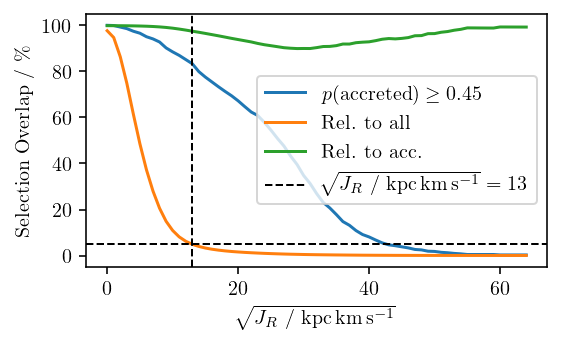

In [34]:
def plot_overlap_versus_sqrtJR(
    probability_threshold=0.45
    ):
    
    f, ax = plt.subplots(figsize=(4,2.5))

    ax.set_xlabel(r'$\sqrt{J_R~/~\mathrm{kpc\,km\,s^{-1}}}$')
    ax.set_ylabel('Selection Overlap / \%')
    probability_all = np.zeros(np.shape(xdgmm['selection']))
    probability_all[xdgmm['selection']] = xdgmm['accreted_proba']

    sqrtJR_array = np.arange(0,65,1)
    overlap_x_accreted = []

    for sqrtJR in sqrtJR_array:

        # accreted both chemically and dynamically
        selection1 = (
            (probability_all >= probability_threshold) &
            (data['sqrt_J_R'] > sqrtJR)
        )
        selection2 = (
            (probability_all >= probability_threshold)
        )
        
        overlap_x_accreted.append(
            len(data['sobject_id'][selection1])/len(data['sobject_id'][selection2]))

    ax.plot(
        sqrtJR_array,
        np.array(overlap_x_accreted)*100,
        label=r'$p (\text{accreted}) \geq 0.45$'
    )
    
    overlap_x_rel_all = []
    for sqrtJR in sqrtJR_array:

        # accreted both chemically and dynamically
        selection1 = (
            (probability_all < probability_threshold) &
            (data['sqrt_J_R'] > sqrtJR)
        )
        selection2 = (
            (probability_all < probability_threshold)
        )
        
        overlap_x_rel_all.append(
            len(data['sobject_id'][selection1])/len(data['sobject_id'][selection2]))


    ax.plot(
        sqrtJR_array,
        np.array(overlap_x_rel_all)*100,
        label=r'Rel. to all'
    )
    
    overlap_x_rel_chem = []
    for sqrtJR in sqrtJR_array:

        # accreted both chemically and dynamically
        selection1 = (
            (probability_all < probability_threshold) &
            (data['sqrt_J_R'] > sqrtJR)
        )
        selection2 = (
            #(probability_all < probability_threshold) &
            (data['sqrt_J_R'] > sqrtJR)
        )
        
        overlap_x_rel_chem.append(
            len(data['sobject_id'][selection1])/len(data['sobject_id'][selection2]))


    ax.plot(
        sqrtJR_array,
        np.array(overlap_x_rel_chem)*100,
        label=r'Rel. to acc.'
    )
    
    overlap_table = Table()
    overlap_table['probability'] = sqrtJR_array
    overlap_table['overlap_x_accreted'] = np.array(overlap_x_accreted)
    overlap_table['overlap_x_rel_all'] = np.array(overlap_x_rel_all)
    overlap_table['overlap_x_rel_chem'] = np.array(overlap_x_rel_chem)

    below_5percent1 = np.where(overlap_table['overlap_x_rel_all'] < 0.05)[0][0]
    #below_5percent2 = np.where(overlap_table['overlap_x_rel_chem'] < 0.05)[0][0]
    ax.axhline(5,c='k',lw=1,ls='dashed',label=r'$\sqrt{J_R~/~\mathrm{kpc\,km\,s^{-1}}} = '+"{:.0f}".format(overlap_table['probability'][below_5percent1])+'$')
    #ax.axhline(5,c='r',lw=1,ls='dashed',label=r'$\sqrt{J_R~/~\mathrm{kpc\,km\,s^{-1}}} = '+"{:.0f}".format(overlap_table['probability'][below_5percent2])+'$')
    ax.axvline(overlap_table['probability'][below_5percent1],c='k',lw=1,ls='dashed')
    #ax.axvline(overlap_table['probability'][below_5percent2],c='r',lw=1,ls='dashed')
    
    #np.savetxt('../depending_text/jr_5percent_contamination.tex',["{:.0f}".format(overlap_table['probability'][below_5percent])+'%'],fmt='%s')
    #np.savetxt('../depending_text/jr_5percent_contamination_overlap.tex',["{:.0f}".format(100*overlap_table['overlap_x_accreted'][below_5percent])+'\% %'],fmt='%s')

    ax.legend()
    plt.tight_layout()
    plt.savefig('sqrtJR_overlap.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()

plot_overlap_versus_sqrtJR()

0.45
0.8798856053384175
0.048786933067994934


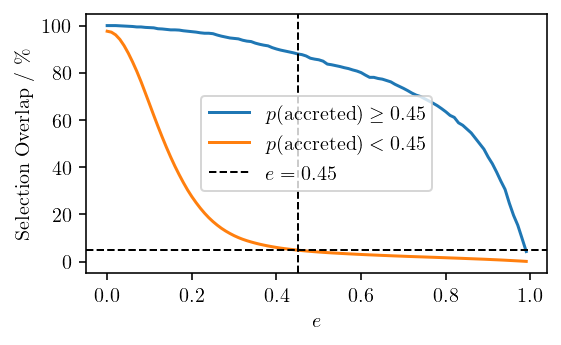

In [35]:
def plot_overlap_versus_ecc(
    probability_threshold=0.45
    ):
    
    f, ax = plt.subplots(figsize=(4,2.5))

    ax.set_xlabel(r'$e$')
    ax.set_ylabel('Selection Overlap / \%')
    probability_all = np.zeros(np.shape(xdgmm['selection']))
    probability_all[xdgmm['selection']] = xdgmm['accreted_proba']

    ecc_array = np.arange(0,1,0.01)
    overlap_x_accreted = []

    for ecc in ecc_array:

        # accreted both chemically and dynamically
        selection1 = (
            (probability_all >= probability_threshold) &
            (data['ecc'] > ecc)
        )
        selection2 = (
            (probability_all >= probability_threshold)
        )
        
        overlap_x_accreted.append(
            len(data['sobject_id'][selection1])/len(data['sobject_id'][selection2]))

    ax.plot(
        ecc_array,
        np.array(overlap_x_accreted)*100,
        label=r'$p (\text{accreted}) \geq 0.45$'
    )
    
    overlap_x_rest = []
    for ecc in ecc_array:

        # accreted both chemically and dynamically
        selection1 = (
            (probability_all < probability_threshold) &
            (data['ecc'] > ecc)
        )
        selection2 = (
            (probability_all < probability_threshold)
        )
        
        overlap_x_rest.append(
            len(data['sobject_id'][selection1])/len(data['sobject_id'][selection2]))

    ax.plot(
        ecc_array,
        np.array(overlap_x_rest)*100,
        label=r'$p (\text{accreted}) < 0.45$'
    )
    
    overlap_table = Table()
    overlap_table['probability'] = ecc_array
    overlap_table['overlap_x_accreted'] = np.array(overlap_x_accreted)
    overlap_table['overlap_x_rest'] = np.array(overlap_x_rest)

    below_5percent = np.where(overlap_table['overlap_x_rest'] < 0.05)[0][0]
    ax.axhline(5,c='k',lw=1,ls='dashed',label=r'$e = '+"{:.2f}".format(overlap_table['probability'][below_5percent])+'$')
    ax.axvline(overlap_table['probability'][below_5percent],c='k',lw=1,ls='dashed')

    print(overlap_table['probability'][below_5percent])
    print(overlap_table['overlap_x_accreted'][below_5percent])
    print(overlap_table['overlap_x_rest'][below_5percent])

    ax.legend()
    plt.tight_layout()
    plt.savefig('ecc_overlap.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()

plot_overlap_versus_ecc()

In [36]:
def plot_density(x, y, bins=100, range=None, normed=False, weights=None, 
                 scaling=None, reduce_fn='sum', smooth=0, ax=None, cmin=0, cmin_limit=1, **kwargs):
    """
    Compute the bi-dimensional histogram of two data samples.

    Parameters
    ----------
    x : array_like, shape (N,)
        An array containing the x coordinates of the points to be
        histogrammed.
    y : array_like, shape (N,)
        An array containing the y coordinates of the points to be
        histogrammed.
    bins : int or array_like or [int, int] or [array, array], optional
        The bin specification:

        * If int, the number of bins for the two dimensions (nx=ny=bins).
        * If array_like, the bin edges for the two dimensions
            (x_edges=y_edges=bins).
        * If [int, int], the number of bins in each dimension
            (nx, ny = bins).
        * If [array, array], the bin edges in each dimension
            (x_edges, y_edges = bins).
        * A combination [int, array] or [array, int], where int
            is the number of bins and array is the bin edges.

    range : array_like, shape(2,2), optional
        The leftmost and rightmost edges of the bins along each dimension
        (if not specified explicitly in the `bins` parameters):
        ``[[xmin, xmax], [ymin, ymax]]``. All values outside of this range
        will be considered outliers and not tallied in the histogram.
    normed : bool, optional
        If False, returns the number of samples in each bin. If True,
        returns the bin density ``bin_count / sample_count / bin_area``.
    weights : array_like, shape(N,), optional
        An array of values ``w_i`` weighing each sample ``(x_i, y_i)``.
        Weights are normalized to 1 if `normed` is True. If `normed` is
        False, the values of the returned histogram are equal to the sum of
        the weights belonging to the samples falling into each bin.
    """
    import pylab as plt
    from scipy.ndimage import gaussian_filter

    ind = (np.isfinite(x) & np.isfinite(y))
    if False in ind:
        print("Warning: Not all values are finite.")
        w = weights
        if w is not None:
            w = w[ind]
        n, bx, by = plt.histogram2d(x[ind], y[ind], bins=bins, range=range, normed=normed,
                                    weights=w)
    else:
        n, bx, by = plt.histogram2d(x, y, bins=bins, range=range, normed=normed,
                                    weights=weights)

    if reduce_fn.lower() in ('average', 'mean', 'avg'):
        n0, _, _ = plt.histogram2d(x, y, bins=bins, range=range, normed=normed,
                                   weights=None)
        
        cmin_limit = (n0 < cmin)
        ind = n0 > 0
        n = n.astype(float)
        n[ind] /= n0[ind].astype(float)
    n[(n==0)] = np.nan
    n[cmin_limit] = np.nan

    defaults = dict(zorder = 2, cmap='RdYlBu_r', origin='lower', aspect='auto', rasterized=True,
                    interpolation='nearest')
    defaults.update(**kwargs)
    extent = (bx[0], bx[-1], by[0], by[-1])

    if smooth > 0:
        gaussian_filter(n, smooth, output=n)

    if ax==None:
        ax = plt.gca()
    else:
        ax=ax
        
    if scaling is None:
        scaling = 'None'
    s = scaling.lower().replace(' ', '')
    if s in (None, 'none', 'count'):
        return ax.imshow(n.T, extent=extent, **defaults)#, n
    else:
        if s in ('log', 'log(n)', 'log10', 'log(count)'):
            return ax.imshow(np.log10(n).T, extent=extent, **defaults)#, np.log10(n)
        elif s in ('log(n+1)', 'log(count+1)'):
            return ax.imshow(np.log10(n + 1).T, extent=extent, **defaults)#, np.log10(n + 1)

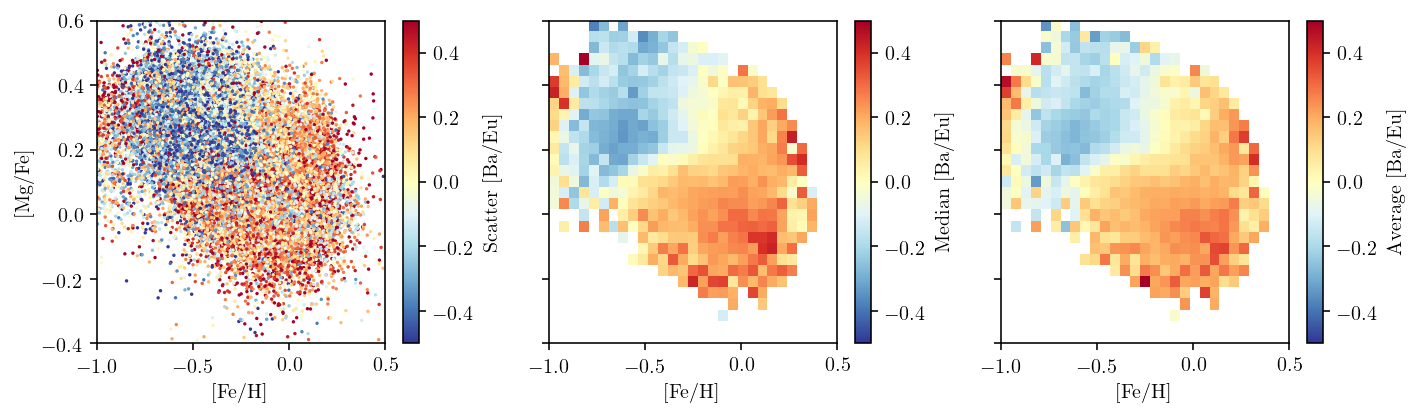

In [95]:
def hist2d_bin_colored(X,Y,Z,X_label='X\_label',Y_label='Y\_label',Z_label='Z\_label',bins=30,bin_function='median',ax=None,minimum_bin_entries = 5,**kwargs):
    """
    INPUT:
    X : x-axis parameter
    Y : y-axis parameter
    Z : parameter that will be used for coloring the bins
    bin_function : median/average/sum
    
    OUTPUT:
    plt.imshow
    """
    
    # First make sure we only work with finite values
    finite = np.isfinite(X) & np.isfinite(Y) & np.isfinite(Z)
    if len(X[finite])!=len(X):
        print('Not all values were finite! Continuing with only finite ones')
    X=X[finite];Y=Y[finite];Z=Z[finite]
    
    # Now create the matrix of bins and its bin-edges
    H,xedges,yedges = np.histogram2d(X,Y,bins=bins)

    # Create the matrix that we want to store color-values in
    color_matrix = np.zeros_like(H)
    color_matrix[:] = np.nan
    
    # Loop through the x- and y-bins
    for x_bin in range(len(xedges)-1):
        for y_bin in range(len(yedges)-1):
            in_xy_bin = (X>=xedges[x_bin])&(X<xedges[x_bin+1])&(Y>=yedges[y_bin])&(Y<yedges[y_bin+1])
            
            # We only add a value if there are more than *minimum_bin_entries* in the bin
            if len(Z[in_xy_bin]) >= minimum_bin_entries:
                if bin_function=='median':
                    color_matrix[x_bin,y_bin]=np.median(Z[in_xy_bin])
                elif bin_function=='average':
                    color_matrix[x_bin,y_bin]=np.average(Z[in_xy_bin])
                elif bin_function=='sum':
                    color_matrix[x_bin,y_bin]=np.sum(Z[in_xy_bin])
                else:
                    raise NameError('Only bin_function = median/average/sum available')

    # Create an axis if not given
    if ax==None:
        ax = plt.gca()
    else:
        ax=ax
    ax.set_xlabel(X_label)
    ax.set_ylabel(Y_label)

    # Populate the keyword arguments for the imshow
    imshow_kwargs = dict(
        cmap = 'seismic_r',aspect='auto',origin='lower'
    )
    # Update by any arguments given through **kwargs
    imshow_kwargs.update(kwargs)

    # Plot!
    s = ax.imshow(color_matrix.T,extent=(xedges[0],xedges[-1],yedges[0],yedges[-1]),**imshow_kwargs)
    c = plt.colorbar(s, ax=ax)
    c.set_label(Z_label)

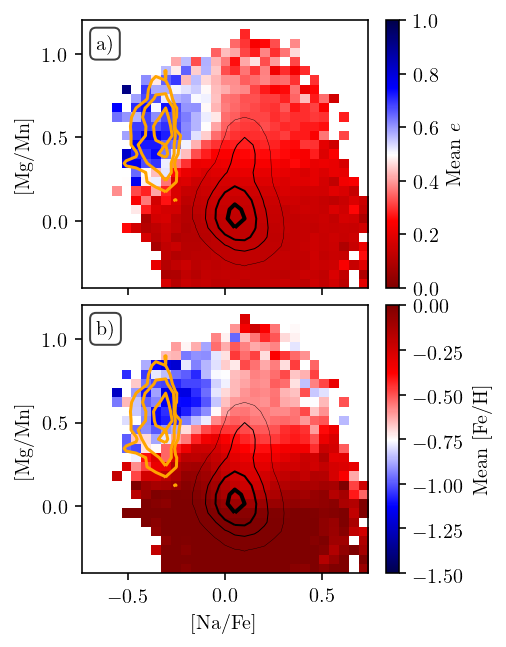

In [37]:
def plot_NaFe_MgMn_Fe_H_ecc():
    f, gs = plt.subplots(2,1,figsize=(3.5,4.6),sharex=True,sharey=True)

    selection = basic_cuts & (data['flag_Mg_fe'] == 0) & (data['flag_Na_fe'] == 0) & (data['flag_Mn_fe'] == 0)

    ax=gs[0]
    s = plot_density(
        data['Na_fe'][selection],
        data['MgMn_fe'][selection],
        weights=data['ecc'][selection],
        cmin=5,
        vmin=0,vmax=1,
        reduce_fn='mean',
        bins = (
                np.linspace(ranges['Na_fe'][0],ranges['Na_fe'][1],30),
                np.linspace(ranges['MgMn_fe'][0],ranges['MgMn_fe'][1],30)
            ),
        range=[ranges['Na_fe'],ranges['MgMn_fe']],
        zorder=0,
        cmap='seismic_r',
        ax=ax
    )
    ax.set_ylabel('[Mg/Mn]')
    c = plt.colorbar(s, ax=ax)
    c.set_label(r'Mean $e$')
    plot_background(ax=ax,x_elem='Na_fe',y_elem='MgMn_fe',no_fill_contours=True,plot_datapoints=False,plot_density=False)
    plot_chemical(ax=ax,x_elem='Na_fe',y_elem='MgMn_fe',no_fill_contours=True,plot_datapoints=False,plot_density=False)
    ax.text(0.05,0.95,'a)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

    # colored by [Fe/H]
    ax = gs[1]
    s = plot_density(
        data['Na_fe'][selection],
        data['MgMn_fe'][selection],
        weights=data['fe_h'][selection],
        vmin = -1.5,vmax=0.,
        cmin= 5,
        reduce_fn='mean',
        range=[ranges['Na_fe'],ranges['MgMn_fe']],
        bins = (
                np.linspace(ranges['Na_fe'][0],ranges['Na_fe'][1],30),
                np.linspace(ranges['MgMn_fe'][0],ranges['MgMn_fe'][1],30)
            ),
        zorder=0,
        cmap='seismic',
        ax=ax
    )
    c = plt.colorbar(s, ax=ax)
    c.set_label(r'Mean [Fe/H]')
    plot_background(ax=ax,x_elem='Na_fe',y_elem='MgMn_fe',no_fill_contours=True,plot_datapoints=False,plot_density=False)
    plot_chemical(ax=ax,x_elem='Na_fe',y_elem='MgMn_fe',no_fill_contours=True,plot_datapoints=False,plot_density=False)
    ax.set_ylabel('[Mg/Mn]')
    ax.set_xlabel('[Na/Fe]')
    ax.text(0.05,0.95,'b)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

    plt.tight_layout(h_pad=0)
    plt.savefig('NaFe_MgMn_Fe_H_ecc.png',dpi=200,bbox_inches='tight')
plot_NaFe_MgMn_Fe_H_ecc()

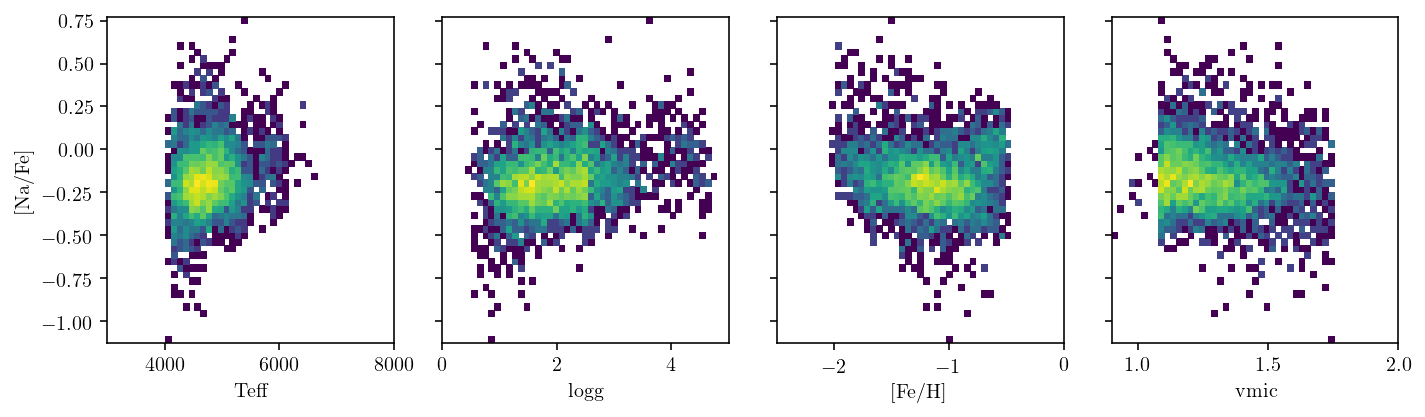

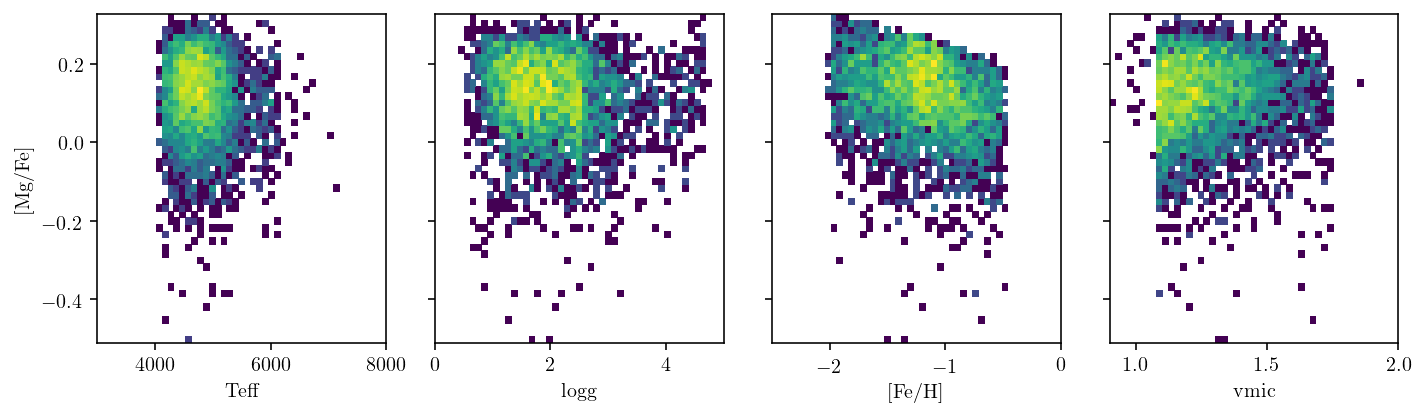

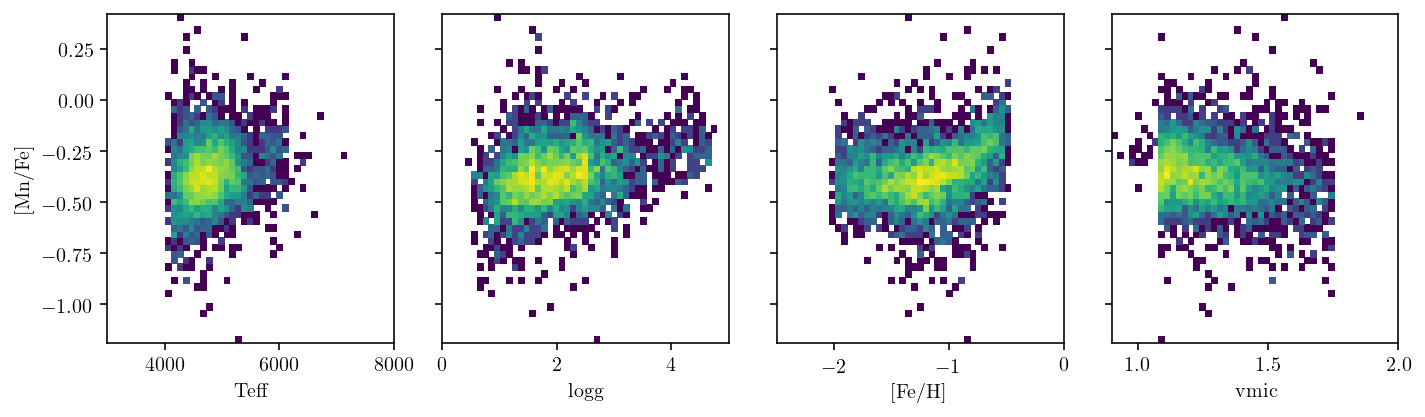

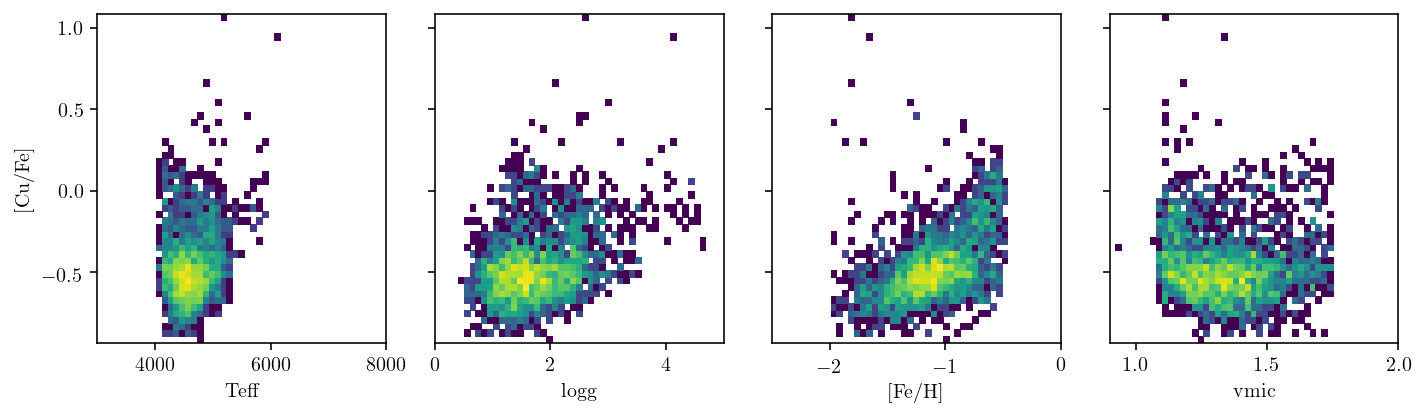

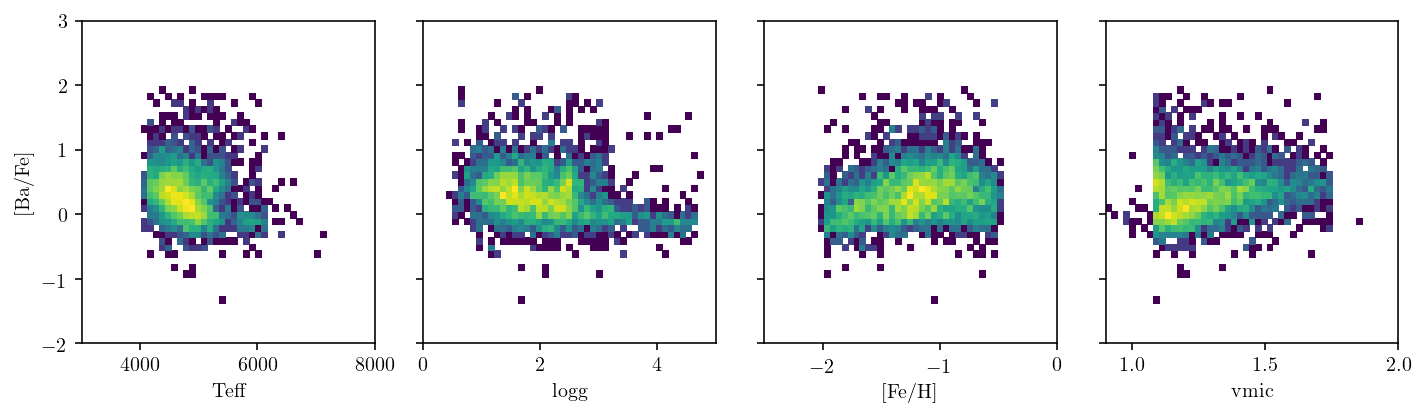

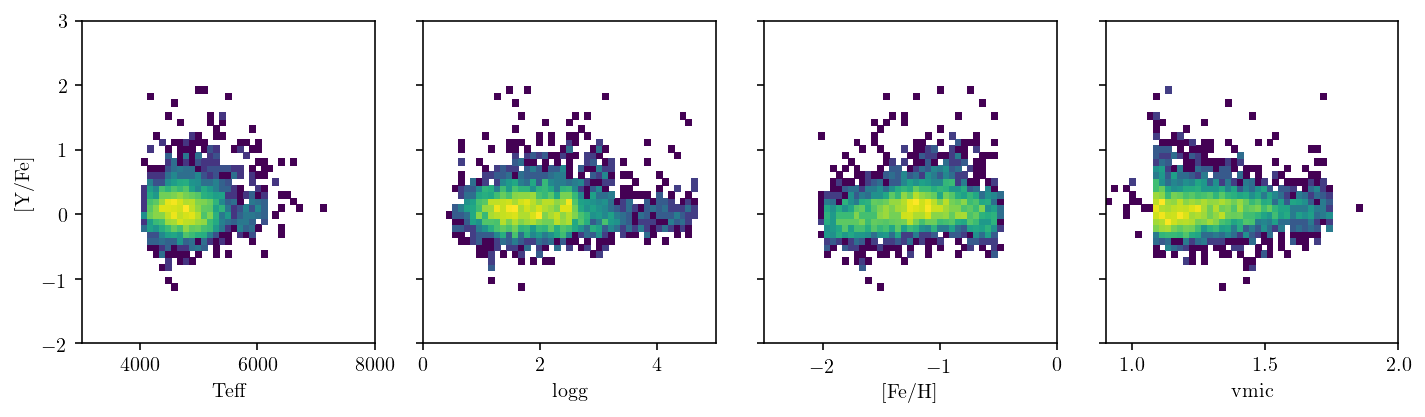

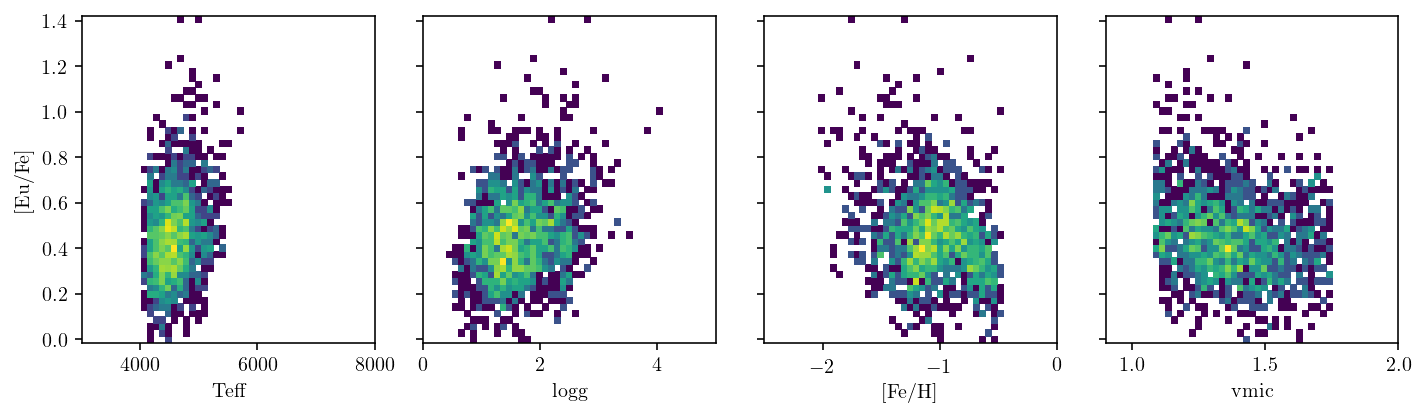

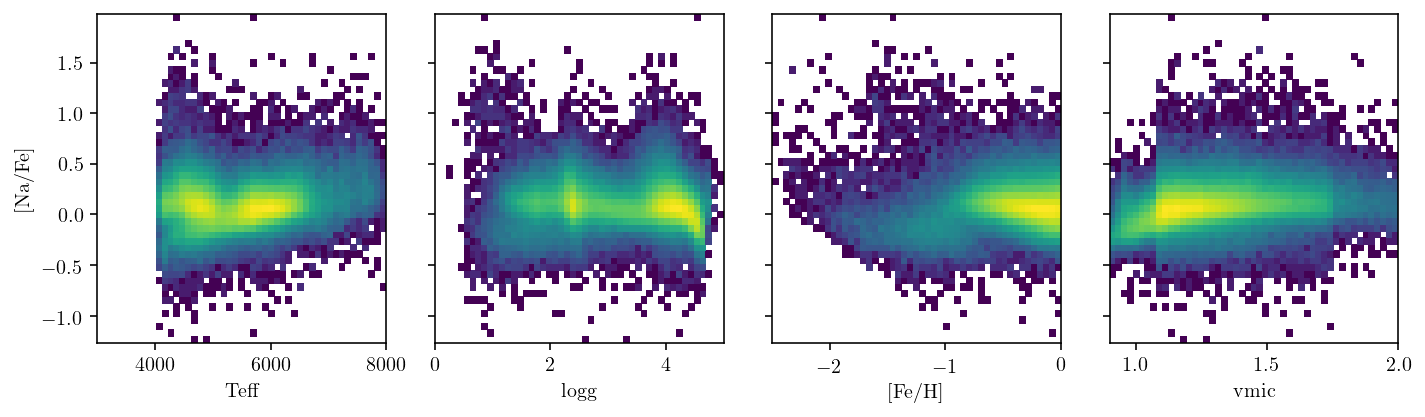

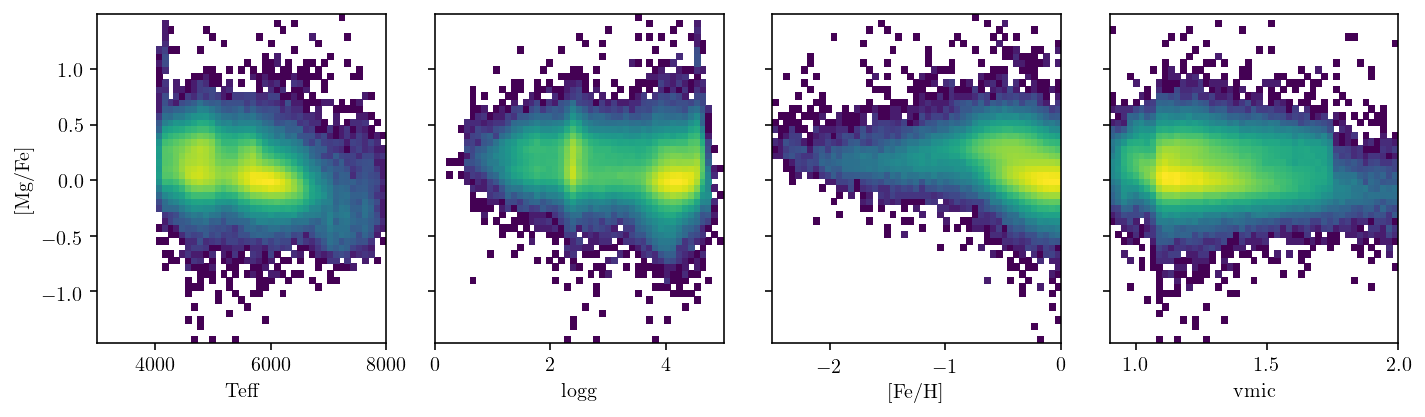

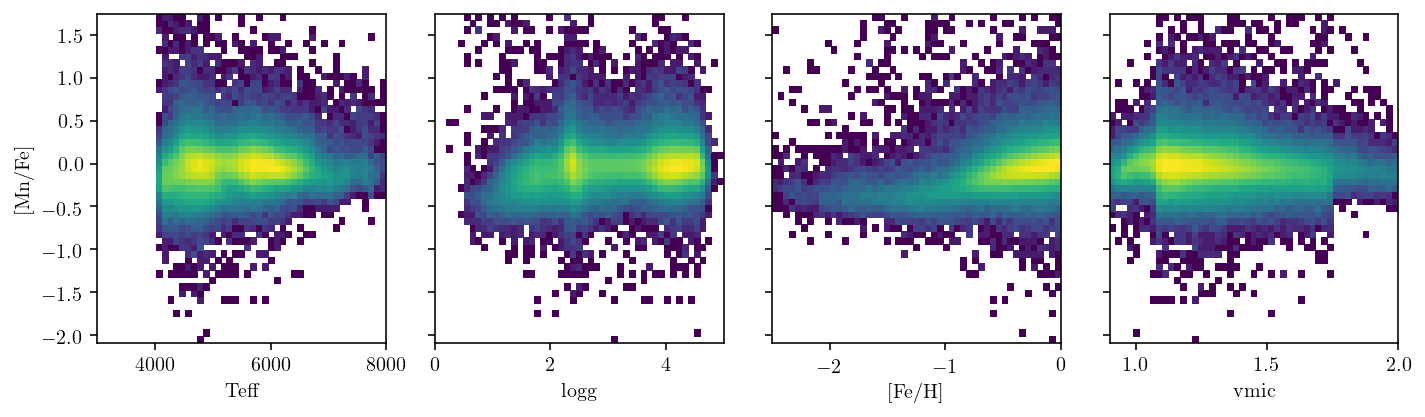

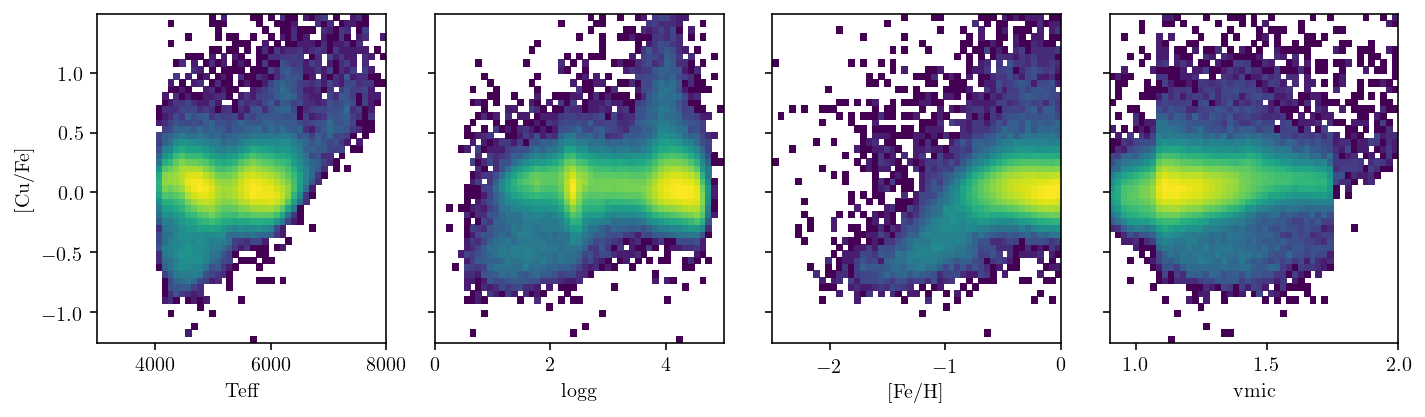

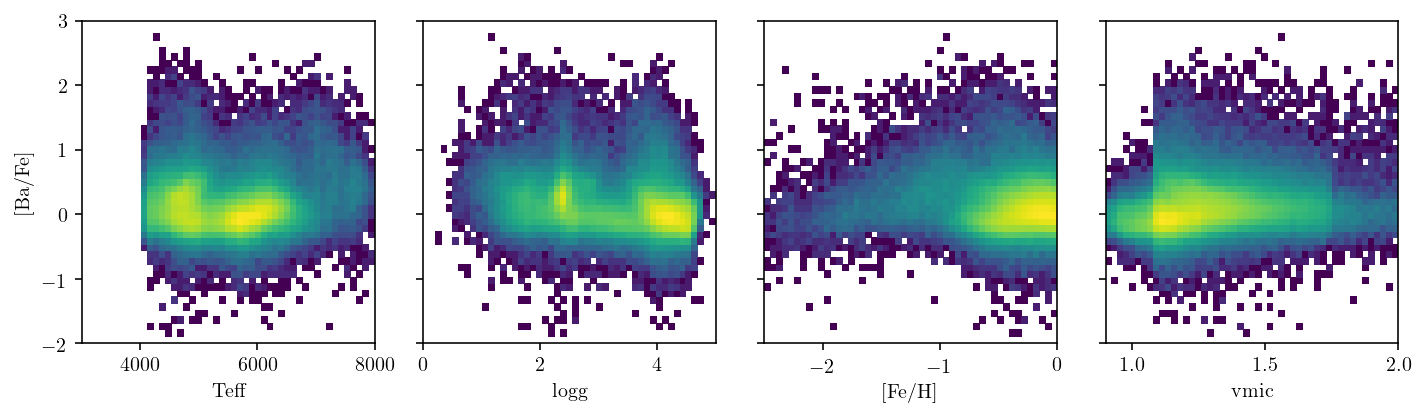

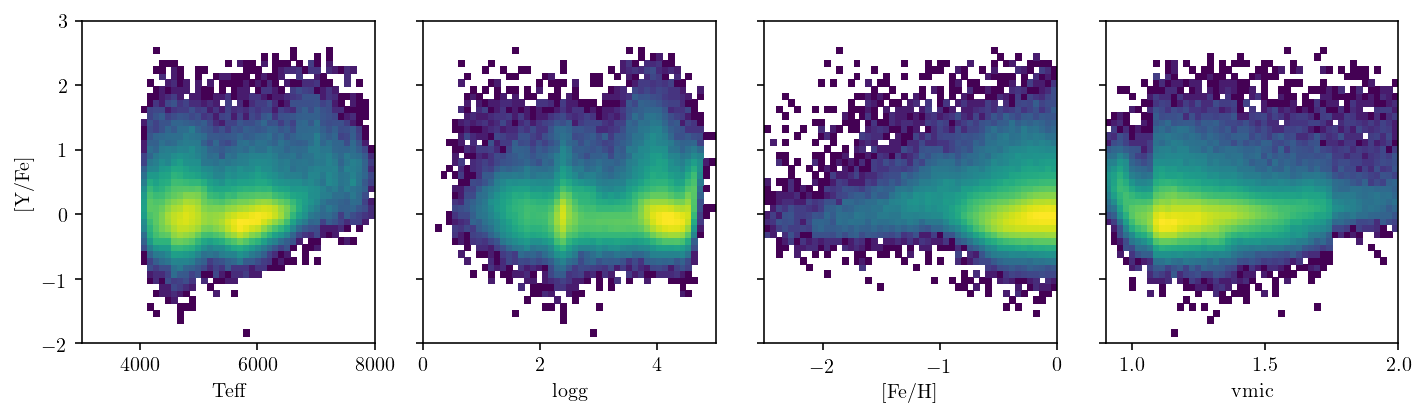

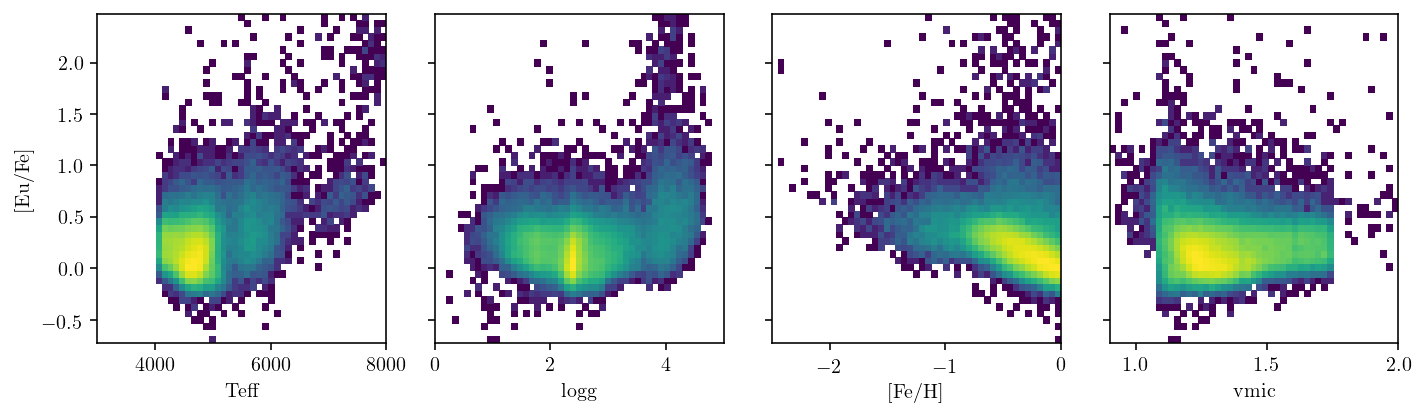

In [119]:
elements = ['Na','Mg','Mn','Cu','Ba','Y','Eu']

for each_element in elements:
    f, gs = plt.subplots(1,4,sharey=True,figsize=(10,3))
    #selection1 = basic_cuts & (data['flag_'+each_element+'_fe']==0)
    selection1 = preliminary_low_alpha_halo & (data['flag_'+each_element+'_fe']==0)# & (data['logg'] > 2) & (~(data['Cu_fe'] > -0.2))
    if each_element == 'Y':
        ybins = np.linspace(-2,3,50)
    elif each_element == 'Ba':
        ybins = np.linspace(-2,3,50)
    else:
        ybins = 50
        
    ax=gs[0]
    ax.hist2d(
        data['teff'][selection1],
        data[each_element+'_fe'][selection1],
        bins=(np.linspace(3000,8000,50),ybins),cmin=1,norm=LogNorm()
    )
    ax.set_xlabel('Teff')
    ax.set_ylabel('['+each_element+'/Fe]')
    ax=gs[1]
    ax.hist2d(
        data['logg'][selection1],
        data[each_element+'_fe'][selection1],
        bins=(np.linspace(0,5,50),ybins),cmin=1,norm=LogNorm()
    )
    ax.set_xlabel('logg')
    ax=gs[2]
    ax.hist2d(
        data['fe_h'][selection1],
        data[each_element+'_fe'][selection1],
        bins=(np.linspace(-2.5,0,50),ybins),cmin=1,norm=LogNorm()
    )
    ax.set_xlabel('[Fe/H]')
    ax=gs[3]
    ax.hist2d(
        data['vmic'][selection1],
        data[each_element+'_fe'][selection1],
        bins=(np.linspace(0.9,2,50),ybins),cmin=1,norm=LogNorm()
    )
    ax.set_xlabel('vmic')

    plt.tight_layout()
    plt.savefig('trends_'+each_element+'_lowalphahalo.png',bbox_inches='tight',dpi=200)
    

for each_element in elements:
    f, gs = plt.subplots(1,4,sharey=True,figsize=(10,3))
    selection1 = basic_cuts & (data['flag_'+each_element+'_fe']==0)
    #selection1 = preliminary_low_alpha_halo & (data['flag_'+each_element+'_fe']==0)# & (data['logg'] > 2) & (~(data['Cu_fe'] > -0.2))

    if each_element == 'Y':
        ybins = np.linspace(-2,3,50)
    elif each_element == 'Ba':
        ybins = np.linspace(-2,3,50)
    else:
        ybins = 50
    
    ax=gs[0]
    ax.hist2d(
        data['teff'][selection1],
        data[each_element+'_fe'][selection1],
        bins=(np.linspace(3000,8000,50),ybins),cmin=1,norm=LogNorm()
    )
    ax.set_xlabel('Teff')
    ax.set_ylabel('['+each_element+'/Fe]')
    ax=gs[1]
    ax.hist2d(
        data['logg'][selection1],
        data[each_element+'_fe'][selection1],
        bins=(np.linspace(0,5,50),ybins),cmin=1,norm=LogNorm()
    )
    ax.set_xlabel('logg')
    ax=gs[2]
    ax.hist2d(
        data['fe_h'][selection1],
        data[each_element+'_fe'][selection1],
        bins=(np.linspace(-2.5,0,50),ybins),cmin=1,norm=LogNorm()
    )
    ax.set_xlabel('[Fe/H]')
    ax=gs[3]
    ax.hist2d(
        data['vmic'][selection1],
        data[each_element+'_fe'][selection1],
        bins=(np.linspace(0.9,2,50),ybins),cmin=1,norm=LogNorm()
    )
    ax.set_xlabel('vmic')

    plt.tight_layout()
    plt.savefig('trends_'+each_element+'_all.png',bbox_inches='tight',dpi=200)

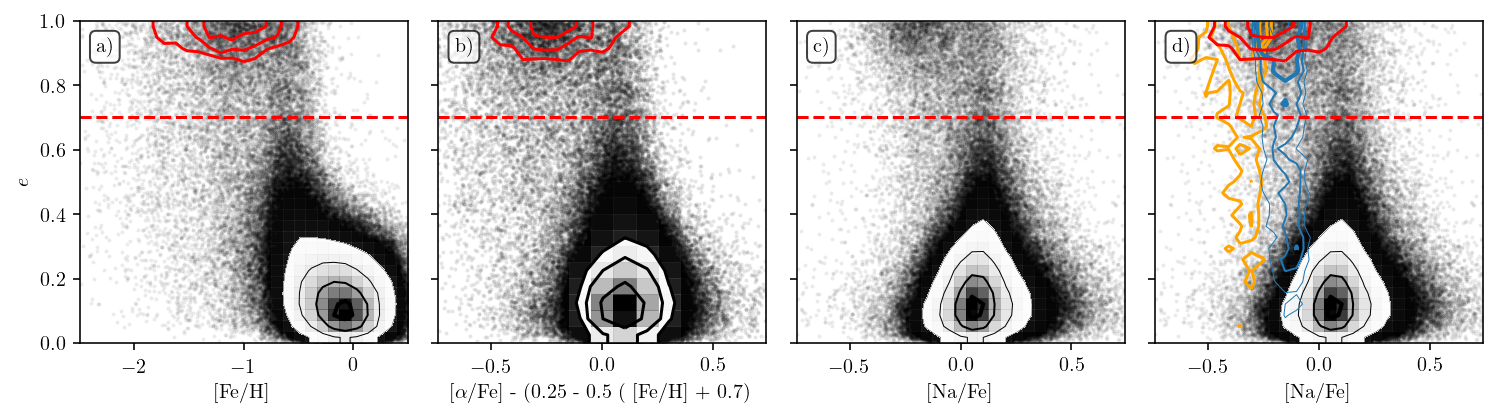

In [38]:
def plot_nafe_e():
    f, gs = plt.subplots(1,4,figsize=(10.5,3),sharey=True)

    ax=gs[0]
    ax.set_ylabel(r'$e$')
    ax.set_xlabel('[Fe/H]')
    plot_background(ax=ax,x_elem='fe_h',y_elem='ecc',data_kwargs=dict(alpha=0.08))
    ax.axhline(0.7,c='r',ls='dashed')
    plot_dynamical(ax=ax,x_elem='fe_h',y_elem='ecc')
    ax.text(0.05,0.95,'a)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

    ax=gs[1]
    corner.hist2d(
        data['alpha_fe'][basic_cuts] - (0.25 - 0.5*(data['fe_h'][basic_cuts] + 0.7)),
        data['ecc'][basic_cuts],
        ax=ax,
        range=[(-1.24,0.75),(0,1)]
    )
    plot_dynamical(ax=ax,x_elem='Na_fe',y_elem='ecc')
    ax.set_xlabel(r'[$\alpha$/Fe] - (0.25 - 0.5 ( [Fe/H] + 0.7)')
    ax.axhline(0.7,c='r',ls='dashed')
    ax.text(0.05,0.95,'b)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

    ax=gs[2]
    ax.set_xlabel('[Na/Fe]')
    plot_background(ax=ax,x_elem='Na_fe',y_elem='ecc',data_kwargs=dict(alpha=0.08))
    ax.axhline(0.7,c='r',ls='dashed')
    ax.text(0.05,0.95,'c)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    
    ax=gs[3]
    ax.set_xlabel('[Na/Fe]')
    plot_background(ax=ax,x_elem='Na_fe',y_elem='ecc',data_kwargs=dict(alpha=0.08))
    plot_chemical(ax=ax,x_elem='Na_fe',y_elem='ecc')
    plot_chemical(ax=ax,x_elem='Na_fe',y_elem='ecc',component=3,color='C0')
    plot_dynamical(ax=ax,x_elem='Na_fe',y_elem='ecc')
    ax.axhline(0.7,c='r',ls='dashed')
    ax.text(0.05,0.95,'d)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    
    plt.tight_layout(h_pad=0,w_pad=0)
    plt.savefig('nafe_e.png',dpi=200,bbox_inches='tight')
plot_nafe_e()

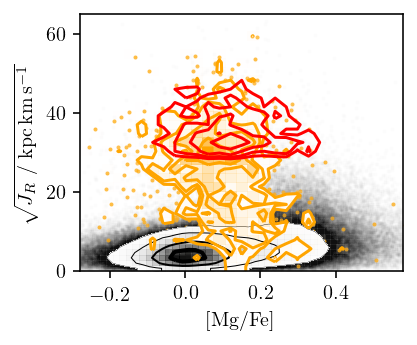

In [23]:
def plot_overlap_mgfe_sqrtjr():
    f, ax = plt.subplots(figsize=(3,2.5))
    plot_background(ax=ax,x_elem='Mg_fe',y_elem='sqrt_J_R',bins=50)
    plot_chemical(ax=ax,x_elem='Mg_fe',y_elem='sqrt_J_R',no_fill_contours=False,plot_datapoints=True,
        plot_density=True)
    plot_dynamical(ax=ax,x_elem='Mg_fe',y_elem='sqrt_J_R')
    ax.set_xlabel('[Mg/Fe]')
    ax.set_ylabel(r'$\sqrt{J_R~/~\mathrm{kpc\,km\,s^{-1}}}$')
    
    chemical_selection_msto = (probability_all >= 0.45) & msto

#     s = plt.scatter(
#         data['Mg_fe'][chemical_selection_msto],
#         data['sqrt_J_R'][chemical_selection_msto],
#         c=data['age_bstep'][chemical_selection_msto],
#         zorder=6
#     )
#     plt.colorbar(s)

    plt.tight_layout()
    plt.savefig('overlap_mgfe_sqrtjr.png',dpi=200,bbox_inches='tight')
plot_overlap_mgfe_sqrtjr()

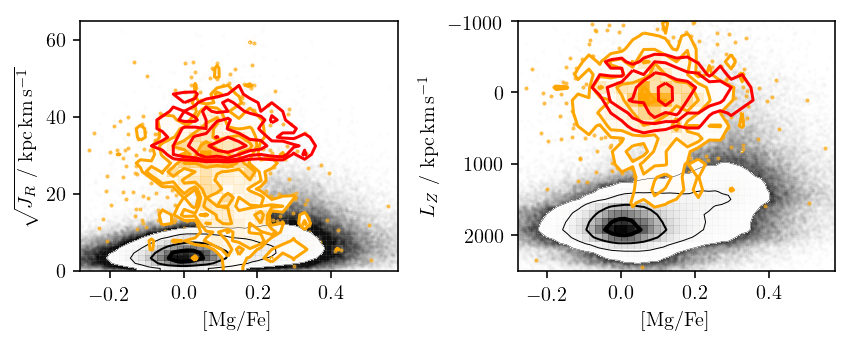

In [135]:
def plot_overlap_mgfe_sqrtjr_lz():
    f, gs = plt.subplots(1,2,figsize=(6,2.5))
    
    ax=gs[0]
    plot_background(ax=ax,x_elem='Mg_fe',y_elem='sqrt_J_R',bins=50)
    plot_chemical(ax=ax,x_elem='Mg_fe',y_elem='sqrt_J_R',no_fill_contours=False,plot_datapoints=True,
        plot_density=True)
    plot_dynamical(ax=ax,x_elem='Mg_fe',y_elem='sqrt_J_R')
    ax.set_xlabel('[Mg/Fe]')
    ax.set_ylabel(r'$\sqrt{J_R~/~\mathrm{kpc\,km\,s^{-1}}}$')
    
    ax=gs[1]
    plot_background(ax=ax,x_elem='Mg_fe',y_elem='L_Z',bins=50)
    plot_chemical(ax=ax,x_elem='Mg_fe',y_elem='L_Z',no_fill_contours=False,plot_datapoints=True,
        plot_density=True)
    plot_dynamical(ax=ax,x_elem='Mg_fe',y_elem='L_Z')
    ax.set_ylim(2500,-1000)
    ax.set_xlabel('[Mg/Fe]')
    ax.set_ylabel(r'$L_Z~/~\mathrm{kpc\,km\,s^{-1}}$')

    plt.tight_layout()
    
plot_overlap_mgfe_sqrtjr_lz()

This asymmetric table can be read in the following way: The overlap between ``This Work'' and `` F+21'' is 296 spectra. That is 28\% of ``This Work'' (1049 spetra) and 26\% of ``F+21'' (1141 spetra).


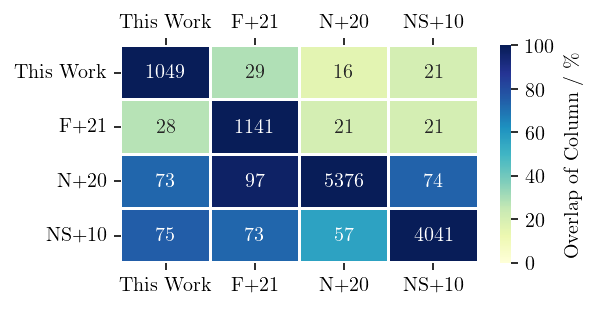

In [46]:
def plot_heat_map():
    """
    
    """
    
    prediction_all = -1*np.ones(np.shape(xdgmm['selection']))
    prediction_all[xdgmm['selection']] = xdgmm['prediction_proba'][:,0] + xdgmm['prediction_proba'][:,3] 

    samples = [
        #(prediction_all >= 0.45),
        (probability_all >= 0.45),
        gse_f21,
        naidu2020,
        preliminary_low_alpha_halo
    ]
    minimal_criteria = [
        basic_cuts & (data['flag_Na_fe'] == 0) & (data['flag_Mg_fe'] == 0) & (data['flag_Mn_fe'] == 0),
        basic_cuts,
        basic_cuts & (data['flag_alpha_fe'] == 0),
        basic_cuts & (data['flag_Mg_fe'] == 0)
    ]
    
    #labels = ['[Na/Fe] vs. [Mg/Mn]',r'$L_Z$ vs. $\sqrt{J_R}$',r'$e$ vs. [Fe/H] vs. [$\alpha$/Fe]',r'low-$\alpha$ halo']
    labels = ['This Work','F+21','N+20','NS+10']
    
    # Print how it works:
    cell_0_1 = len(data['sobject_id'][(samples[0] & samples[1])])
    group0 = len(data['sobject_id'][(samples[0])])
    group1 = len(data['sobject_id'][(samples[1])])
    
    explanation = "This asymmetric table can be read in the following way: The overlap between ``"+labels[0]+"'' and `` "+labels[1]+"'' is "+str(cell_0_1)+" spectra. That is "+str(int(np.round(100*cell_0_1/group0)))+"\\% of ``"+labels[0]+"'' ("+str(group0)+" spetra) and "+str(int(np.round(100*cell_0_1/group1)))+"\\% of ``"+labels[1]+"'' ("+str(group1)+" spetra)."
    print(explanation)
    np.savetxt('../depending_text/correlation_explanation.tex',[explanation],fmt='%s')
    
    correlation = []

    for e_c, each_column in enumerate(samples):

        column = []

        for e_r, each_row in enumerate(samples):

            cell_number = len(data['sobject_id'][(each_column & each_row)])

            each_column_min = minimal_criteria[e_c]
            each_row_min = minimal_criteria[e_r]
            column_number = len(data['sobject_id'][each_column & each_column_min & each_row_min])
            
            if e_r == e_c:
                column.append(cell_number)
            else:
                column.append(np.round(100*cell_number/column_number))

        correlation.append(column)

    f, ax = plt.subplots(figsize=(4, 2))
    ax = sns.heatmap(
        np.array(correlation).T, 
        xticklabels=labels,
        yticklabels=labels,
        linewidths=1,
        cbar_kws={'label': r'Overlap of Column / \%'},
        fmt='.0f', vmin=0, vmax=100, annot=True, cmap="YlGnBu")
    ax.set_yticklabels(labels=ax.get_yticklabels(), va='center')
    ax.tick_params(top=True, labeltop=True)

    plt.savefig('selection_overlap.png',dpi=300,bbox_inches='tight')

plot_heat_map()